# Data Preparation and Analysis

In [480]:
import json
from pathlib import Path
from datetime import datetime
import pandas as pd
#from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline
import numpy as np
import altair as alt
from string import ascii_letters
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from bokeh.layouts import column
from bokeh.models import (ColumnDataSource, DataTable, HoverTool, IntEditor,
                          NumberEditor, NumberFormatter, SelectEditor,
                          StringEditor, StringFormatter, TableColumn)
from bokeh.plotting import figure, show
from bokeh.sampledata.autompg2 import autompg2 as mpg
from bokeh.plotting import figure, output_notebook, show

import plotly.express as px

import urllib.request

#json==2.0.9
#pandas==1.5.3
#matplotlib==3.7.0
#seaborn==0.12.2
#numpy==1.23.5
#altair==4.2.2

# Asteroids - Dataset 

The data is about Asteroids and is provided by *(Neo - Browse)* asteroid dataset of [NASA Asteroids NeoWS](https://api.nasa.gov/).

The dataset consists of 32020 asteroids.

From all the availiable features the following were used:
- `name`: This feature contains the name of the asteroid
- `absolute_magnitude_h`: This feature contains the absolute magnitude of an asteroid. An asteroid’s absolute magnitude is the visual magnitude an observer would record if the asteroid were placed 1 Astronomical Unit (AU) away, and 1 AU from the Sun and at a zero phase angle.
- `max_diameter`: This feature contains the asteroids max diameter
- `min_diameter`: This feature contains the asteroids min diameter
- `average_diameter`: This feature contains the asteroids average diameter (not provided by dataset, derived from `max_diameter` and `mix_diameter` features).
- `hazardous`: This feature is True or False whether the asteroid is hazardous or not.
- `orbit_class_type`: This feature contains the type of orbit class the asteroids belong; Asteroids are divided into groups/classes based on their semi-major axis, perihelion distance, and aphelion distance: Atiras, Apollos, Amors and Athens
- `inclination`:  This feature contains the tilt of the orbit from the reference plane
- `orbital_period`: This feature contains the value of the orbital period of the asteroid. Orbital period refers to the time taken by the asteroid to make one full revolution around its orbiting body.
- `semi_major_axis`: This feature contains the value of the Semi Major Axis of the asteroid’s orbit. The realm of an asteroid is elliptical rather than circular.
- `eccentricity`: This feature contains the orbital eccentricity of the asteroid.

- `close_approach_date`: This feature contains the date of which the asteroid will be closer to its orbiting body.
- `miss_distance`: This feature contains the distance which the asteroid misses its orbiting body.
- `orbiting_body`: This feature contains the planet around which the asteroid is revolving.
- `relative_velocity`: This feature contains the relative velocity of the asteroid in kilometre per hour.

## Data Preparation

Read data from the `asteroids.json` file (produced by Task1)

In [481]:
asteroids_filename = 'Full_asteroids'
close_approach_data_filename = 'Full_close_approach_data'

In [482]:
filename = asteroids_filename + ".json"
fin = open(filename,"r")
full_data = json.load(fin)
fin.close()

Parse each individual raw JSON data. 

Data referring to asteroids characteristics (such name, magnitude, orbital information etc) is stored in `asteroids` dataframe.

Approach data (such as close approach date, planet to which the asteroid appoaches etc) is strored in `close_approach_data` dataframe.

The `asteroids` dataframe contains the following fields: `name`, `absolute_magnitude_h`, `max_diameter`, `min_diameter`, `average_diameter` (derived not provided), `hazardous`, `orbit_class_type`, `inclination`, `orbital_period`, `semi_major_axis`and `eccentricity`.


The `close_approach_data` dataframe contains the following fields: `name`, `hazardous`, `close_approach_date`, `miss_distance`, `orbiting_body`, `relative_velocity` and `average_diameter`.

In [483]:
rows = []
approach_rows = []

for i in range(len(full_data)):
    ob_list = full_data[i]

    asteri = pd.DataFrame(ob_list)
    #asteroids.to_csv(filename)
    for index, row in asteri.iterrows():
        #print("------", row["id"], row["name"])
        rowobj = {}
        rowobj["name"] = row["name"]

        rowobj["absolute_magnitude_h"] = row["absolute_magnitude_h"]
        
        #Some asteroids do not have estimated_diameter section
        if(pd.notnull(row['estimated_diameter'])): 
            rowobj["max_diameter"] = row["estimated_diameter"]["kilometers"]["estimated_diameter_max"]
            rowobj["min_diameter"] = row["estimated_diameter"]["kilometers"]["estimated_diameter_min"]
            # Compute the average diameter of each asteroid 
            rowobj["average_diameter"] = (row["estimated_diameter"]["kilometers"]["estimated_diameter_max"]+row["estimated_diameter"]["miles"]["estimated_diameter_min"])/2

        rowobj["hazardous"] = row["is_potentially_hazardous_asteroid"]
        
        #Some asteroids do not have orbital_data section
        if(pd.notnull(row['orbital_data'])):
            rowobj["orbit_class_type"] = row["orbital_data"]["orbit_class"]["orbit_class_type"]
            rowobj["inclination"] = row["orbital_data"]["inclination"]
            rowobj["orbital_period"] = row["orbital_data"]["orbital_period"]
            rowobj["semi_major_axis"] = row["orbital_data"]["semi_major_axis"]
            rowobj["eccentricity"] = row["orbital_data"]["eccentricity"]
            
        #Some asteroids do not have close_approach_data section
        if len(row["close_approach_data"]) != 0 :
            for ap in row["close_approach_data"]:
                approach_row = {}
                approach_row["name"] = rowobj["name"]
                approach_row["hazardous"] = rowobj["hazardous"]
                approach_row["close_approach_date"] = ap["close_approach_date"]
                approach_row["miss_distance"] = ap["miss_distance"]["kilometers"]
                approach_row["orbiting_body"] = ap["orbiting_body"]
                approach_row["relative_velocity"] = ap["relative_velocity"]["kilometers_per_second"]
                approach_row["average_diameter"] = (row["estimated_diameter"]["kilometers"]["estimated_diameter_max"]+row["estimated_diameter"]["kilometers"]["estimated_diameter_min"])/2
                approach_rows.append(approach_row)       
        rows.append(rowobj)  

In [484]:
asteroids = pd.DataFrame(rows)
close_approach_data = pd.DataFrame(approach_rows)

### Data Verification

Check the format and the size of `asteroids` dataframe

In [485]:
asteroids.head(5)

name  absolute_magnitude_h  max_diameter  min_diameter  \
0      433 Eros (A898 PA)                 10.31     51.527608     23.043847   
1    719 Albert (A911 TB)                 15.59      4.529393      2.025606   
2    887 Alinda (A918 AA)                 13.83     10.186852      4.555699   
3  1036 Ganymed (A924 UB)                  9.21     85.514543     38.243266   
4    1221 Amor (1932 EA1)                 17.38      1.986278      0.888290   

   average_diameter  hazardous orbit_class_type        inclination  \
0         32.923193      False              AMO  10.82782330218545   
1          2.894023      False              AMO  11.57600929611851   
2          6.508815      False              AMO  9.396611430341229   
3         54.638900      False              AMO  26.68554038899091   
4          1.269118      False              AMO  11.88324645598894   

      orbital_period    semi_major_axis       eccentricity  
0  643.1205824040848  1.458129136101339  .2227818894620597  
1  1564.252770506612  2.637175327507462  .5470449589266008  
2  1420.017575924114  2.472465243676928  .5707437328017271  
3  1589.939735445521  2.665967337403487  .5330163657161359  
4  970.8264761006858  1.918795935890222  .4358396273246597

In [486]:
asteroids.shape

(32020, 11)

Check the format and the size of `close_approach_data` dataframe

In [487]:
close_approach_data.head(5)

name  hazardous close_approach_date        miss_distance  \
0  333311 (2001 MR3)      False          1910-06-21    46915158.52756742   
1  333311 (2001 MR3)      False          1921-07-23   68565672.624493328   
2  333311 (2001 MR3)      False          1930-05-05  260652039.860899564   
3  333311 (2001 MR3)      False          1950-06-02   70784247.483245918   
4  333311 (2001 MR3)      False          1961-07-08   50921064.484794845   

  orbiting_body relative_velocity  average_diameter  
0         Earth      2.7393090413           0.68162  
1         Earth       1.344207765           0.68162  
2         Juptr      1.5910181226           0.68162  
3         Earth      2.1637277036           0.68162  
4         Earth      2.7653305265           0.68162

In [488]:
close_approach_data.shape

(14027, 7)

Check for missing data in both dataframes

In [489]:
asteroids.isnull().sum()

name                     4
absolute_magnitude_h    14
max_diameter            14
min_diameter            14
average_diameter        14
hazardous                0
orbit_class_type         4
inclination              4
orbital_period           4
semi_major_axis          4
eccentricity             4
dtype: int64

Get all the rows that contains null values

In [490]:
ast_to_deleted = asteroids[asteroids.isnull().any(axis=1)]

In [491]:
ast_to_deleted

name  absolute_magnitude_h  max_diameter  min_diameter  \
7112   (2010 AW108)                   NaN           NaN           NaN   
7113   (2010 AG127)                   NaN           NaN           NaN   
7164   (2010 CJ188)                   NaN           NaN           NaN   
7300    (2010 GE69)                   NaN           NaN           NaN   
7312    (2010 HE30)                   NaN           NaN           NaN   
7315    (2010 HV83)                   NaN           NaN           NaN   
7416    (2010 MR11)                   NaN           NaN           NaN   
7419   (2010 MY112)                   NaN           NaN           NaN   
7420   (2010 MZ112)                   NaN           NaN           NaN   
24926           NaN                   NaN           NaN           NaN   
28983   (2010 HA71)                   NaN           NaN           NaN   
29120           NaN                   NaN           NaN           NaN   
29121           NaN                   NaN           NaN           NaN   
29363           NaN                   NaN           NaN           NaN   

       average_diameter  hazardous orbit_class_type        inclination  \
7112                NaN      False              AMO  10.99607321794065   
7113                NaN      False              AMO  23.68784707171896   
7164                NaN      False              AMO  22.16270956625734   
7300                NaN      False              AMO  26.47514148160836   
7312                NaN      False              AMO  16.42742484941292   
7315                NaN      False              AMO   11.3747479792566   
7416                NaN      False              AMO  27.83739624030531   
7419                NaN      False              APO  38.58156304124343   
7420                NaN      False              APO  23.58625802216596   
24926               NaN      False              NaN                NaN   
28983               NaN      False              AMO  16.38856750575738   
29120               NaN      False              NaN                NaN   
29121               NaN      False              NaN                NaN   
29363               NaN      False              NaN                NaN   

          orbital_period    semi_major_axis       eccentricity  
7112   626.0820384552007  1.432260050475795  .2804202043963979  
7113   631.7229654378449   1.44085018188138  .1004324108070968  
7164   696.6802495690781  1.538001342594096  .3353790313095167  
7300   858.6573577825724  1.767994783278346  .2739407520904893  
7312   591.3593360124549  1.378802367554874  .1846153012706391  
7315   623.0063566534764  1.427565467763536  .1256109965427932  
7416   694.3080906283184  1.534508150224602  .1604659768208847  
7419   405.2104210566644  1.071654485297153  .2446522900266755  
7420   496.4227258481122  1.226974354307862  .5209013532304808  
24926                NaN                NaN                NaN  
28983  782.9086254188171  1.662423874491788  .2393489860854879  
29120                NaN                NaN                NaN  
29121                NaN                NaN                NaN  
29363                NaN                NaN                NaN

In [492]:
ast_to_deleted.shape

(14, 11)

There are 14 asteroids that contain null values in some of their featutes.

Prior to deletion of these rows (containing null values) check whether any of these asteroids exist in the `close_approach_data` dataframe.

In [493]:
close_approach_data[close_approach_data.name.isin(ast_to_deleted.name)].shape

(0, 7)

No such asteroid exists. So proceed to the deletion.

In [494]:
asteroids = asteroids[asteroids.absolute_magnitude_h.notnull()]

In [495]:
asteroids.shape

(32006, 11)

There are **32006** asteroids in the `asteroids` dataframe.

Check the `close_approach_data` dataframe for null values.

In [496]:
close_approach_data.isnull().sum()

name                   0
hazardous              0
close_approach_date    0
miss_distance          0
orbiting_body          0
relative_velocity      0
average_diameter       0
dtype: int64

No missing values exist. No normalization is required.

Check for duplicates values.

In [497]:
asteroids.duplicated().count()

32006

In [498]:
close_approach_data.duplicated().count()

14027

No duplicates exist.


### Data Saving

Write out all 'clean' data into `Full_asteroids.csv` and `Full_close_approach_data` files. These data will be used for the data analysis

In [499]:
astr_filename = asteroids_filename + ".csv"
cad_filename = close_approach_data_filename + ".csv"
asteroids.to_csv(astr_filename)
close_approach_data.to_csv(cad_filename)

## Data Analysis

### Data Loading

Reload astroids data frames. (This step can be skipped).

In [500]:
asteroids = pd.read_csv(astr_filename, index_col="name")
close_approach_data = pd.read_csv(cad_filename, index_col="name")

Check the format and the shape of `asteroids` and `close_approach_data` dataframes

In [501]:
asteroids.head(5)

Unnamed: 0  absolute_magnitude_h  max_diameter  \
name                                                                     
433 Eros (A898 PA)               0                 10.31     51.527608   
719 Albert (A911 TB)             1                 15.59      4.529393   
887 Alinda (A918 AA)             2                 13.83     10.186852   
1036 Ganymed (A924 UB)           3                  9.21     85.514543   
1221 Amor (1932 EA1)             4                 17.38      1.986278   

                        min_diameter  average_diameter  hazardous  \
name                                                                
433 Eros (A898 PA)         23.043847         32.923193      False   
719 Albert (A911 TB)        2.025606          2.894023      False   
887 Alinda (A918 AA)        4.555699          6.508815      False   
1036 Ganymed (A924 UB)     38.243266         54.638900      False   
1221 Amor (1932 EA1)        0.888290          1.269118      False   

                       orbit_class_type  inclination  orbital_period  \
name                                                                   
433 Eros (A898 PA)                  AMO    10.827823      643.120582   
719 Albert (A911 TB)                AMO    11.576009     1564.252771   
887 Alinda (A918 AA)                AMO     9.396611     1420.017576   
1036 Ganymed (A924 UB)              AMO    26.685540     1589.939735   
1221 Amor (1932 EA1)                AMO    11.883246      970.826476   

                        semi_major_axis  eccentricity  
name                                                   
433 Eros (A898 PA)             1.458129      0.222782  
719 Albert (A911 TB)           2.637175      0.547045  
887 Alinda (A918 AA)           2.472465      0.570744  
1036 Ganymed (A924 UB)         2.665967      0.533016  
1221 Amor (1932 EA1)           1.918796      0.435840

In [502]:
close_approach_data.head(5)

Unnamed: 0  hazardous close_approach_date  miss_distance  \
name                                                                          
333311 (2001 MR3)           0      False          1910-06-21   4.691516e+07   
333311 (2001 MR3)           1      False          1921-07-23   6.856567e+07   
333311 (2001 MR3)           2      False          1930-05-05   2.606520e+08   
333311 (2001 MR3)           3      False          1950-06-02   7.078425e+07   
333311 (2001 MR3)           4      False          1961-07-08   5.092106e+07   

                  orbiting_body  relative_velocity  average_diameter  
name                                                                  
333311 (2001 MR3)         Earth           2.739309           0.68162  
333311 (2001 MR3)         Earth           1.344208           0.68162  
333311 (2001 MR3)         Juptr           1.591018           0.68162  
333311 (2001 MR3)         Earth           2.163728           0.68162  
333311 (2001 MR3)         Earth           2.765331           0.68162

In [503]:
asteroids.shape

(32006, 11)

In [504]:
close_approach_data.shape

(14027, 7)

In [505]:
asteroids = asteroids.drop('Unnamed: 0', axis=1)
close_approach_data = close_approach_data.drop('Unnamed: 0', axis=1)

### Analysis of Impact Risk

A potentially `hazardous` asteroid is a near-Earth object with an orbit that can make close approaches to the Earth and which is large enough to cause significant regional damage in the event of impact.

In [506]:
haz = asteroids["hazardous"].value_counts()
haz

False    29632
True      2374
Name: hazardous, dtype: int64

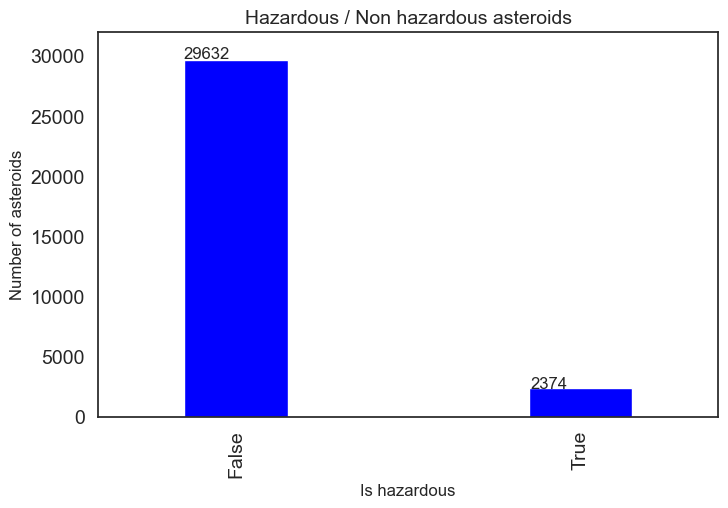

In [507]:
ax = haz.plot(kind="bar", figsize=(8, 5), fontsize=14, color="blue", width=0.3)
# customize the axes and title
if (asteroids_filename == 'asteroids'):
    ax.set_ylim((0,50))
else:
    ax.set_ylim((0,32000))
ax.set_xlabel("Is hazardous", fontsize=12)
ax.set_ylabel("Number of asteroids", fontsize=12)
ax.set_title("Hazardous / Non hazardous asteroids", fontsize=14);

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

Among the **32006** asteroids in the dataset, **2374** are indicated as potential hazardous asteroids.

List hazardous asteroids sorted by their absolute magnitude value.

In [508]:
asteroids[asteroids["hazardous"]==True].sort_values('absolute_magnitude_h')

absolute_magnitude_h  max_diameter  min_diameter  \
name                                                                         
3122 Florence (1981 ET3)                 13.88      9.954971      4.451998   
4183 Cuno (1959 LM)                      14.18      8.670417      3.877528   
3200 Phaethon (1983 TB)                  14.39      7.871182      3.520100   
16960 (1998 QS52)                        14.42      7.763186      3.471802   
242450 (2004 QY2)                        14.60      7.145621      3.195619   
...                                        ...           ...           ...   
(2003 GR22)                              22.16      0.219806      0.098300   
(2001 XP31)                              22.16      0.219806      0.098300   
469445 (2002 LT24)                       22.19      0.216790      0.096952   
(2000 WC1)                               22.20      0.215794      0.096506   
(2004 HG12)                              22.40      0.196807      0.088015   

                          average_diameter  hazardous orbit_class_type  \
name                                                                     
3122 Florence (1981 ET3)          6.360657       True              AMO   
4183 Cuno (1959 LM)               5.539900       True              APO   
3200 Phaethon (1983 TB)           5.029235       True              APO   
16960 (1998 QS52)                 4.960231       True              APO   
242450 (2004 QY2)                 4.565643       True              APO   
...                                    ...        ...              ...   
(2003 GR22)                       0.140444       True              APO   
(2001 XP31)                       0.140444       True              APO   
469445 (2002 LT24)                0.138517       True              ATE   
(2000 WC1)                        0.137880       True              ATE   
(2004 HG12)                       0.125748       True              APO   

                          inclination  orbital_period  semi_major_axis  \
name                                                                     
3122 Florence (1981 ET3)    22.143859      859.298096         1.768874   
4183 Cuno (1959 LM)          6.668727     1018.548736         1.981172   
3200 Phaethon (1983 TB)     22.273531      523.590760         1.271342   
16960 (1998 QS52)           17.517279     1192.233506         2.200435   
242450 (2004 QY2)           37.030404      412.190338         1.083926   
...                               ...             ...              ...   
(2003 GR22)                  6.169301      701.378098         1.544908   
(2001 XP31)                  6.132684      448.358253         1.146440   
469445 (2002 LT24)           0.763824      223.166063         0.720034   
(2000 WC1)                  17.407365      301.156993         0.879285   
(2004 HG12)                 26.536814      632.593153         1.442173   

                          eccentricity  
name                                    
3122 Florence (1981 ET3)      0.423217  
4183 Cuno (1959 LM)           0.636016  
3200 Phaethon (1983 TB)       0.889895  
16960 (1998 QS52)             0.858941  
242450 (2004 QY2)             0.477200  
...                                ...  
(2003 GR22)                   0.608528  
(2001 XP31)                   0.385305  
469445 (2002 LT24)            0.495819  
(2000 WC1)                    0.262497  
(2004 HG12)                   0.344966  

[2374 rows x 10 columns]

The asteroid `3122 Florence (1981 ET3)` has the minimum magnιtude.

Compute the mean average diameter of each asteriods category (hazardous / non-hazardous)

In [509]:
groups = asteroids.groupby("hazardous")
groups = groups.mean()

groups[["absolute_magnitude_h", "average_diameter"]]

absolute_magnitude_h  average_diameter
hazardous                                        
False                 23.985786          0.195365
True                  20.187558          0.454030

Generally, more prominent in size are hazardous than those which are comparatively smaller. The mean of the diameter of the asteroids that are labelled as hazardous in this dataset, then it turns out to be 0.45 KM. In contrast, the mean of the diameter of the non-hazardous asteroids turns out to be 0.19 KM.

### Analysis of Asteroids physical information

Check the statistical information for `absolute_magnitude_h`, `average_diameter`, `max_diameter` and `min_diameter` features.

Text(0.5, 1.0, 'Distribution of absolute_magnitute_h')

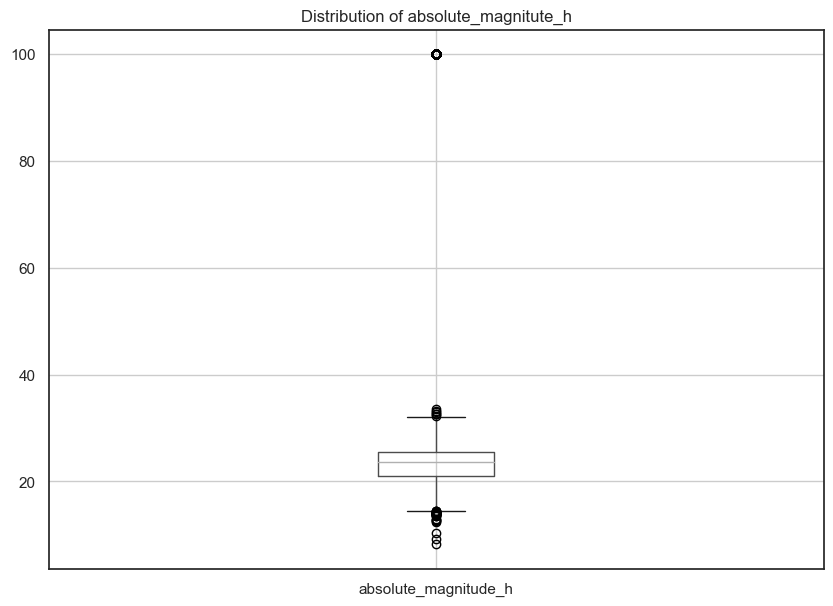

In [510]:
boxplot = asteroids.boxplot(column=['absolute_magnitude_h'], return_type='axes')
plt.title('Distribution of absolute_magnitute_h')

It seems that there are some outlier values.

In [511]:
asteroids["absolute_magnitude_h"].max()

99.99

In [512]:
abs_magn = asteroids[asteroids["absolute_magnitude_h"] > 90]
abs_magn

absolute_magnitude_h  max_diameter  min_diameter  \
name                                                             
(2010 LJ25)                  99.99           0.0           0.0   
(1997 TW8)                   99.99           0.0           0.0   
(2010 AN126)                 99.99           0.0           0.0   
(2010 BZ31)                  99.99           0.0           0.0   
(2010 BJ95)                  99.99           0.0           0.0   
...                            ...           ...           ...   
(2010 OB150)                 99.99           0.0           0.0   
(2010 OG150)                 99.99           0.0           0.0   
(2010 PK82)                  99.99           0.0           0.0   
(2010 PY82)                  99.99           0.0           0.0   
(2010 PC87)                  99.99           0.0           0.0   

              average_diameter  hazardous orbit_class_type  inclination  \
name                                                                      
(2010 LJ25)                0.0      False              APO    10.200752   
(1997 TW8)                 0.0      False              APO    13.379150   
(2010 AN126)               0.0      False              APO    20.705000   
(2010 BZ31)                0.0      False              APO    11.177340   
(2010 BJ95)                0.0      False              AMO     9.385030   
...                        ...        ...              ...          ...   
(2010 OB150)               0.0      False              APO     2.507910   
(2010 OG150)               0.0      False              ATE     1.204520   
(2010 PK82)                0.0      False              APO     0.639460   
(2010 PY82)                0.0      False              ATE     9.465200   
(2010 PC87)                0.0      False              ATE    17.161330   

              orbital_period  semi_major_axis  eccentricity  
name                                                         
(2010 LJ25)       822.066515         1.717404      0.538119  
(1997 TW8)       1988.463817         3.094659      0.678354  
(2010 AN126)      414.077689         1.087232      0.891852  
(2010 BZ31)       441.200947         1.134206      0.728663  
(2010 BJ95)       716.995645         1.567757      0.347682  
...                      ...              ...           ...  
(2010 OB150)      370.161412         1.008932      0.115432  
(2010 OG150)      362.190831         0.994396      0.138549  
(2010 PK82)       372.979326         1.014046      0.034701  
(2010 PY82)       329.670716         0.933945      0.216769  
(2010 PC87)       339.845830         0.953065      0.527807  

[171 rows x 10 columns]

There are **171** asteroids having zero values in min and max diameter features and 99.99 in absolute magnitute feature. This set of asteroids should also be deleted from `asteroids` dataframe. But prior to deletion of these rows, check whether any of these asteroids exist in the `close_approach_data` dataframe.

In [513]:
close_approach_data[close_approach_data.index.isin(abs_magn.index)].shape

(0, 6)

As such asteroid exists in `close_approach_data` dataframe, proceed to the deletion.

In [514]:
asteroids = asteroids.drop(asteroids[asteroids["absolute_magnitude_h"] > 90].index)

In [515]:
asteroids.shape

(31835, 10)

The `asteroids` dataframe contains **31835** asteroids.

Text(0.5, 1.0, 'Distribution of data')

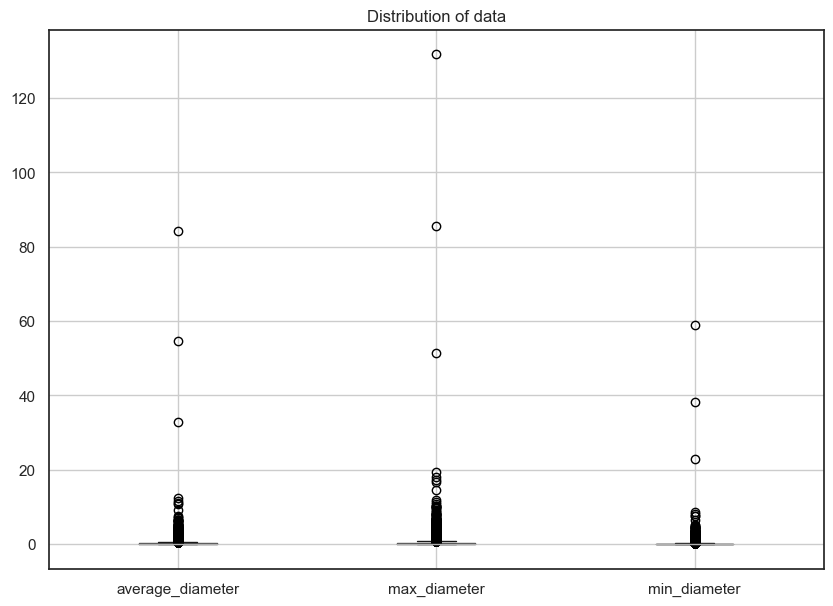

In [516]:
boxplot = asteroids.boxplot(column=['average_diameter','max_diameter', 'min_diameter'], return_type='axes')
plt.title('Distribution of data')

It seems that there are some outlier values in the max and min diameter features. 

In [517]:
asteroids[asteroids["min_diameter"] >20]

absolute_magnitude_h  max_diameter  min_diameter  \
name                                                                       
433 Eros (A898 PA)                     10.31     51.527608     23.043847   
1036 Ganymed (A924 UB)                  9.21     85.514543     38.243266   
(2004 LA33)                             8.27    131.837810     58.959661   

                        average_diameter  hazardous orbit_class_type  \
name                                                                   
433 Eros (A898 PA)             32.923193      False              AMO   
1036 Ganymed (A924 UB)         54.638900      False              AMO   
(2004 LA33)                    84.236816      False              APO   

                        inclination  orbital_period  semi_major_axis  \
name                                                                   
433 Eros (A898 PA)        10.827823      643.120582         1.458129   
1036 Ganymed (A924 UB)    26.685540     1589.939735         2.665967   
(2004 LA33)               86.774903   151224.131838        55.549708   

                        eccentricity  
name                                  
433 Eros (A898 PA)          0.222782  
1036 Ganymed (A924 UB)      0.533016  
(2004 LA33)                 0.989190

In [518]:
minmax_diam = asteroids[asteroids["max_diameter"] >30]
minmax_diam

absolute_magnitude_h  max_diameter  min_diameter  \
name                                                                       
433 Eros (A898 PA)                     10.31     51.527608     23.043847   
1036 Ganymed (A924 UB)                  9.21     85.514543     38.243266   
(2004 LA33)                             8.27    131.837810     58.959661   

                        average_diameter  hazardous orbit_class_type  \
name                                                                   
433 Eros (A898 PA)             32.923193      False              AMO   
1036 Ganymed (A924 UB)         54.638900      False              AMO   
(2004 LA33)                    84.236816      False              APO   

                        inclination  orbital_period  semi_major_axis  \
name                                                                   
433 Eros (A898 PA)        10.827823      643.120582         1.458129   
1036 Ganymed (A924 UB)    26.685540     1589.939735         2.665967   
(2004 LA33)               86.774903   151224.131838        55.549708   

                        eccentricity  
name                                  
433 Eros (A898 PA)          0.222782  
1036 Ganymed (A924 UB)      0.533016  
(2004 LA33)                 0.989190

There are only **3** asteroids that have outlier values in their min and max diameter features. Check whether they exist in the `dataframe`.

In [519]:
close_approach_data[close_approach_data.index.isin(minmax_diam.index)].shape

(0, 6)

Although these 3 asteroids do not exist in the `close_approach_data` dataframe, I decided to keep them in the `asteroids` dataframe and not drop them mainly due the small number (only 3 asteroids).

List the first 10 asteroids with the larger magnitude

In [520]:
max_mag = asteroids.sort_values(by=['absolute_magnitude_h'], ascending=False).head(10)
max_mag

absolute_magnitude_h  max_diameter  min_diameter  \
name                                                            
(2022 WJ1)                 33.570      0.001148      0.000514   
(2008 TS26)                33.200      0.001362      0.000609   
(2021 BO)                  32.950      0.001528      0.000683   
(2023 CX1)                 32.645      0.001758      0.000786   
(2020 CW)                  32.560      0.001828      0.000818   
(2019 AS5)                 32.300      0.002061      0.000922   
(2011 CQ1)                 32.100      0.002260      0.001011   
(2008 UM1)                 32.100      0.002260      0.001011   
(2017 UL6)                 32.000      0.002366      0.001058   
(2019 UN13)                32.000      0.002366      0.001058   

             average_diameter  hazardous orbit_class_type  inclination  \
name                                                                     
(2022 WJ1)           0.000734      False              APO     2.617719   
(2008 TS26)          0.000870      False              APO     0.818533   
(2021 BO)            0.000976      False              ATE     5.292948   
(2023 CX1)           0.001123      False              APO     3.564947   
(2020 CW)            0.001168      False              APO     5.934913   
(2019 AS5)           0.001317      False              APO     0.701468   
(2011 CQ1)           0.001444      False              ATE     5.244373   
(2008 UM1)           0.001444      False              APO     5.285448   
(2017 UL6)           0.001512      False              APO     3.151896   
(2019 UN13)          0.001512      False              APO     1.504017   

             orbital_period  semi_major_axis  eccentricity  
name                                                        
(2022 WJ1)       960.235287         1.904815      0.513162  
(2008 TS26)      973.455553         1.922259      0.569135  
(2021 BO)        336.622988         0.947030      0.143656  
(2023 CX1)       799.198210         1.685404      0.455163  
(2020 CW)        411.282286         1.082333      0.607925  
(2019 AS5)       571.614417         1.347938      0.392491  
(2011 CQ1)       279.364120         0.836337      0.205619  
(2008 UM1)      1305.411664         2.337578      0.682699  
(2017 UL6)       421.740131         1.100604      0.254390  
(2019 UN13)      637.326927         1.449359      0.421535

The asteroid **(2022 WJ1)** has the maximum magnitute (33.570) 

List the first 10 asteroids with the larger size

In [521]:
ave_diam = asteroids.sort_values(by=['average_diameter'], ascending=False).head(10)
ave_diam

absolute_magnitude_h  max_diameter  min_diameter  \
name                                                                           
(2004 LA33)                                 8.27    131.837810     58.959661   
1036 Ganymed (A924 UB)                      9.21     85.514543     38.243266   
433 Eros (A898 PA)                         10.31     51.527608     23.043847   
1866 Sisyphus (1972 XA)                    12.44     19.321462      8.640820   
4954 Eric (1990 SQ)                        12.58     18.115068      8.101305   
(2006 BP140)                               12.70     17.141151      7.665756   
1627 Ivar (1929 SH)                        12.75     16.750971      7.491262   
3552 Don Quixote (1983 SA)                 13.07     14.455728      6.464798   
2212 Hephaistos (1978 SB)                  13.52     11.750057      5.254785   
(2000 QZ258)                               13.61     11.273012      5.041444   

                            average_diameter  hazardous orbit_class_type  \
name                                                                       
(2004 LA33)                        84.236816      False              APO   
1036 Ganymed (A924 UB)             54.638900      False              AMO   
433 Eros (A898 PA)                 32.923193      False              AMO   
1866 Sisyphus (1972 XA)            12.345308      False              APO   
4954 Eric (1990 SQ)                11.574492      False              AMO   
(2006 BP140)                       10.952215      False              APO   
1627 Ivar (1929 SH)                10.702912      False              AMO   
3552 Don Quixote (1983 SA)          9.236383      False              AMO   
2212 Hephaistos (1978 SB)           7.507614      False              APO   
(2000 QZ258)                        7.202810      False              AMO   

                            inclination  orbital_period  semi_major_axis  \
name                                                                       
(2004 LA33)                   86.774903   151224.131838        55.549708   
1036 Ganymed (A924 UB)        26.685540     1589.939735         2.665967   
433 Eros (A898 PA)            10.827823      643.120582         1.458129   
1866 Sisyphus (1972 XA)       41.204926      951.770757         1.893605   
4954 Eric (1990 SQ)           17.429538     1034.371749         2.001638   
(2006 BP140)                 158.375220     3564.293266         4.566499   
1627 Ivar (1929 SH)            8.450606      929.230438         1.863588   
3552 Don Quixote (1983 SA)    31.092523     3216.891751         4.264735   
2212 Hephaistos (1978 SB)     11.542452     1159.518952         2.159996   
(2000 QZ258)                  15.353730    14492.846975        11.633316   

                            eccentricity  
name                                      
(2004 LA33)                     0.989190  
1036 Ganymed (A924 UB)          0.533016  
433 Eros (A898 PA)              0.222782  
1866 Sisyphus (1972 XA)         0.538299  
4954 Eric (1990 SQ)             0.449163  
(2006 BP140)                    0.838755  
1627 Ivar (1929 SH)             0.396465  
3552 Don Quixote (1983 SA)      0.708059  
2212 Hephaistos (1978 SB)       0.837329  
(2000 QZ258)                    0.898743

The asteroid **(2004 LA33)** has the maximum size (average diameter = 84.236816)

Analyze the interrelation of `absolute_magnitude_h` and the `diameter` features.

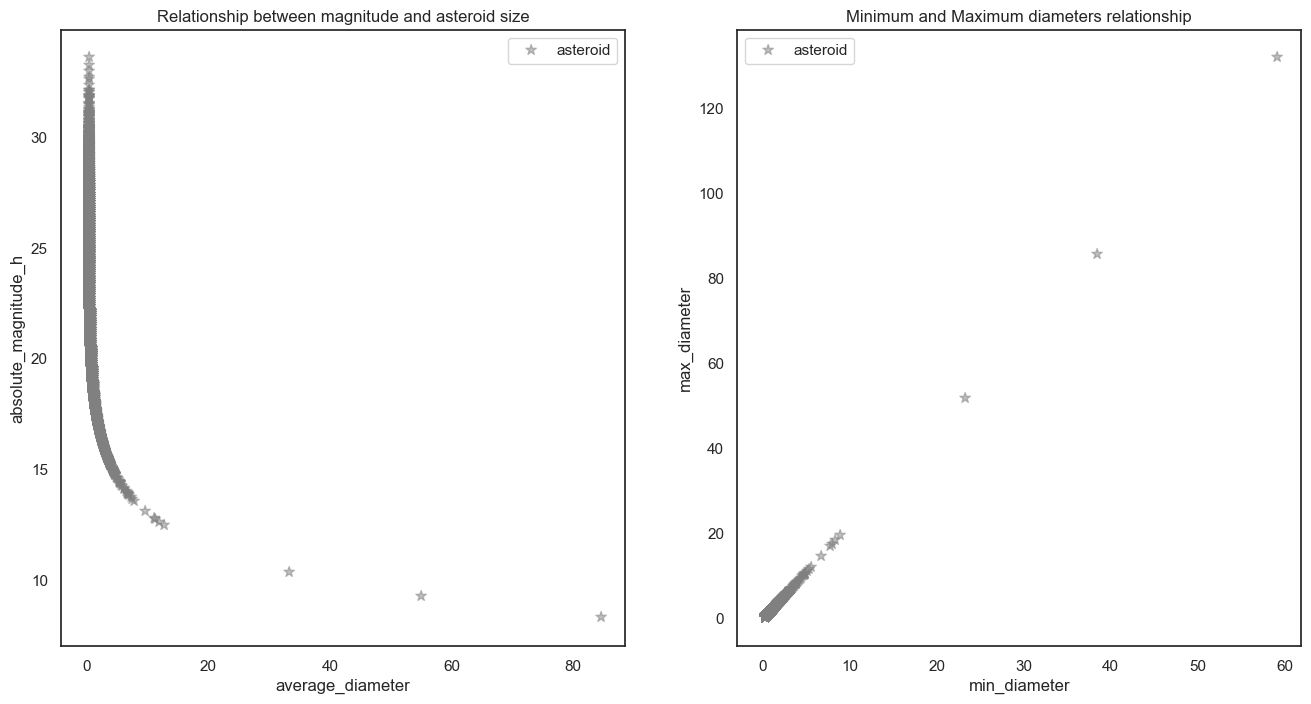

In [522]:
sizes = 100
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(16,8))

ax[0].scatter(asteroids["average_diameter"], asteroids["absolute_magnitude_h"], sizes, c="grey", alpha=0.5, marker=r'$\star$',
           label="asteroid")
ax[0].set_xlabel("average_diameter")
ax[0].set_ylabel("absolute_magnitude_h")
ax[0].title.set_text("Relationship between magnitude and asteroid size")
ax[0].legend()

ax[1].scatter(asteroids["min_diameter"], asteroids["max_diameter"], sizes, c="grey", alpha=0.5, marker=r'$\star$',
           label="asteroid")
ax[1].title.set_text("Minimum and Maximum diameters relationship")
ax[1].set_xlabel("min_diameter")
ax[1].set_ylabel("max_diameter")
ax[1].legend()

plt.show()

**3** asteroids are larger than everyother asteroid and they are:

In [523]:
three_asteria = asteroids.sort_values(by=['average_diameter'], ascending=False).head(3)

three_asteria.iloc[:, 0:4]


absolute_magnitude_h  max_diameter  min_diameter  \
name                                                                       
(2004 LA33)                             8.27    131.837810     58.959661   
1036 Ganymed (A924 UB)                  9.21     85.514543     38.243266   
433 Eros (A898 PA)                     10.31     51.527608     23.043847   

                        average_diameter  
name                                      
(2004 LA33)                    84.236816  
1036 Ganymed (A924 UB)         54.638900  
433 Eros (A898 PA)             32.923193

In addition, asteroids with large magnitude have very small size and as the size of the asteroid is getting larger, its magnidute is getting smaller (left figure). Finally, there is linear positive relation between min and max diameter features (right figure).

The following chart shows the current total number of the asteroids grouped according to their estimated sizes. The first size bin (with 31433 asteroids) represents the smallest asteroids in diameter. The last bin (one asteroid) represents the larger asteroid in diameter.

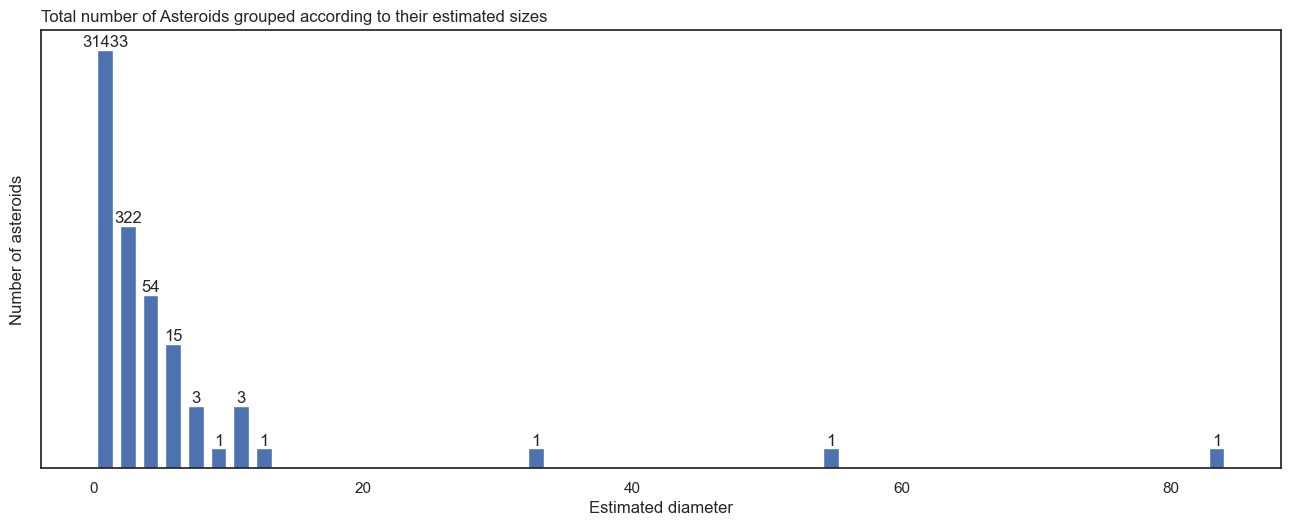

In [524]:
fig = plt.figure(figsize=(16,6))
counts, bins, patches = plt.hist(asteroids["average_diameter"], bins=50, rwidth=0.7)

# plot values on top of bars
plt.bar_label(patches)

plt.yscale('log')
plt.yticks([])

#plt.xticks(bins)
plt.grid(color='white', lw = 0.5, axis='x')
plt.ylabel("Number of asteroids")
plt.xlabel("Estimated diameter")
plt.title('Total number of Asteroids grouped according to their estimated sizes', loc = 'left', fontsize = 12)

plt.subplots_adjust(bottom=0.15)
plt.show()

### Analysis of orbital information

Check the statistical information for `semi_major_axis`, `orbital_period`, `eccentricity` and `inclination` features.

Text(0.5, 1.0, 'Distribution of data')

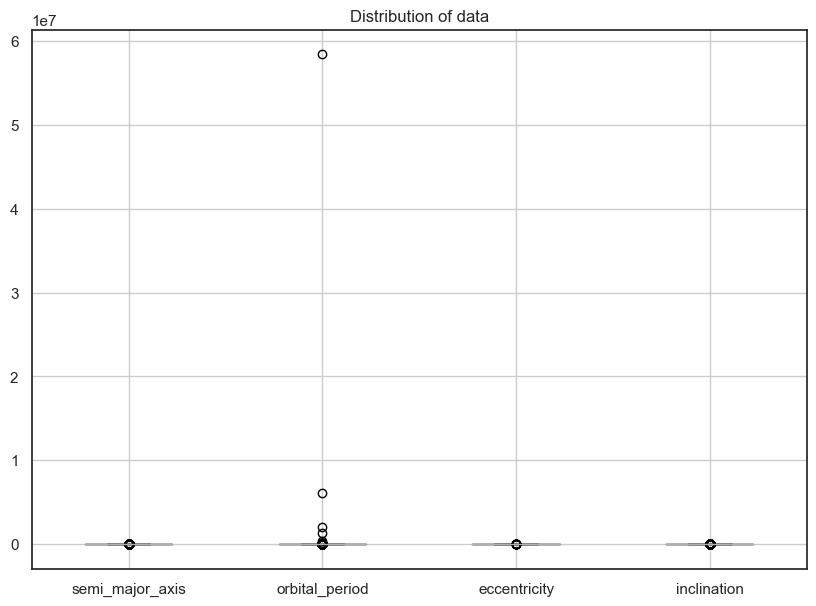

In [525]:
boxplot = asteroids.boxplot(column=['semi_major_axis','orbital_period', 'eccentricity', 'inclination'], return_type='axes')
plt.title('Distribution of data')

It is seams that there is at least one asteroid with outlier value in its `orbital_period` feature.

In [526]:
asteroids["orbital_period"].sort_values(ascending=False)

name
(2003 EG54)                        5.844156e+07
(2011 LX1)                         6.060606e+06
(2017 UR52)                        2.102532e+06
(A/2021 F1)                        1.355436e+06
(2019 EJ3)                         3.582395e+05
                                       ...     
(2020 AV2)                         1.512001e+02
(2019 LF6)                         1.511957e+02
594913 'Aylo'chaxnim (2020 AV2)    1.511916e+02
(2021 VR3)                         1.425197e+02
(2021 PH27)                        1.145757e+02
Name: orbital_period, Length: 31835, dtype: float64

In [527]:
asteroids[asteroids["orbital_period"]>3.582395e+05]

absolute_magnitude_h  max_diameter  min_diameter  \
name                                                            
(2017 UR52)                21.200      0.342011      0.152952   
(A/2021 F1)                14.515      7.430875      3.323189   
(2003 EG54)                18.320      1.288368      0.576176   
(2011 LX1)                 15.890      3.944936      1.764229   

             average_diameter  hazardous orbit_class_type  inclination  \
name                                                                     
(2017 UR52)          0.218525      False              AMO   108.330169   
(A/2021 F1)          4.747904      False              APO   107.314288   
(2003 EG54)          0.823194      False              APO    16.678330   
(2011 LX1)           2.520588      False              AMO    36.656160   

             orbital_period  semi_major_axis  eccentricity  
name                                                        
(2017 UR52)    2.102532e+06       321.190550      0.996111  
(A/2021 F1)    1.355436e+06       239.692088      0.995847  
(2003 EG54)    5.844156e+07      2946.150618      0.999674  
(2011 LX1)     6.060606e+06       650.581299      0.998148

In [528]:
asteroids[asteroids["orbital_period"]>50000].shape

(11, 10)

Only **4** asteroids have orbital period greater than 358239.5 and only **11** has orbital period than 50000. 

A new dataframe called `non_abnormal` is created to store the dataset of asteroids having orbiting period < 50000.

In [529]:
non_abnormal = asteroids.drop(asteroids[asteroids["orbital_period"]>50000].index)

In [530]:
non_abnormal.shape

(31824, 10)

The following figures represent the statistical information for `semi_major_axis`, `orbital_period`, `eccentricity` and `inclination` features in both `asteroids` and `non_abnormal` dataframes.

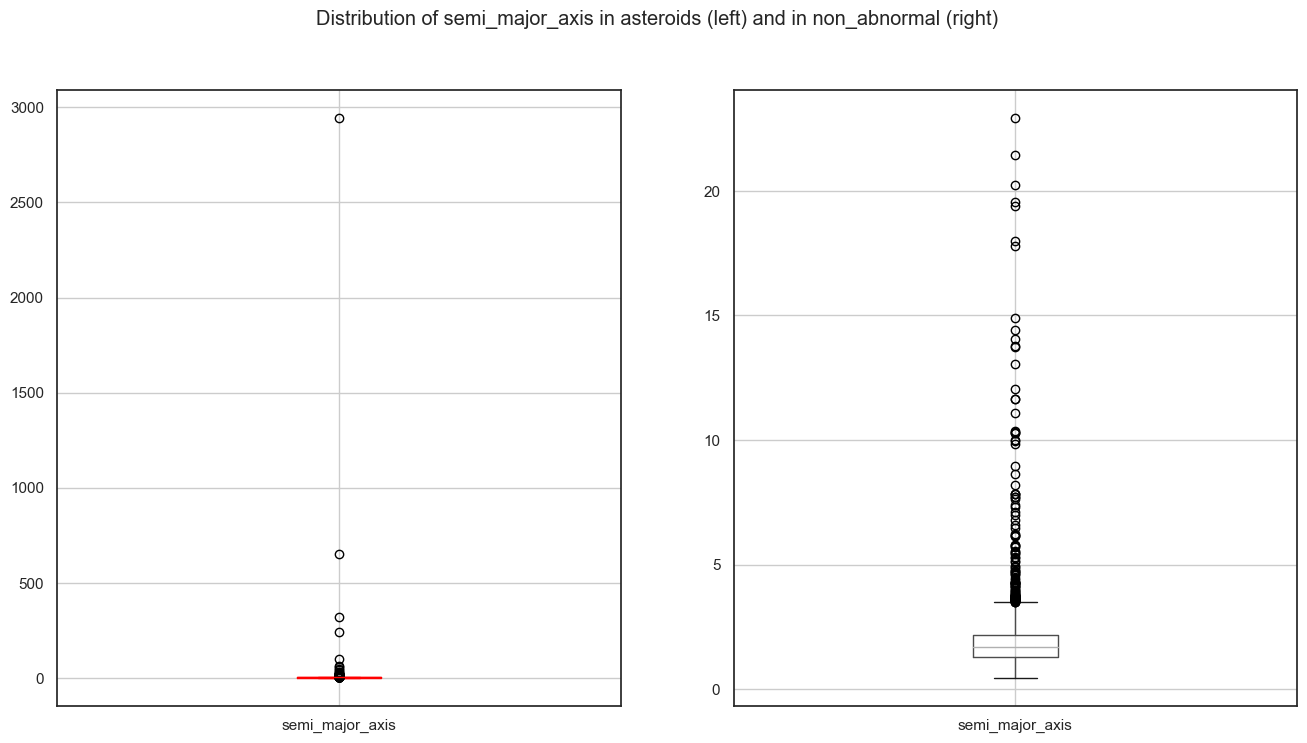

In [531]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8))
asteroids.boxplot(column=['semi_major_axis'], return_type='axes',color="red", ax=ax1)
non_abnormal.boxplot(column=['semi_major_axis'], return_type='axes', ax=ax2)
plt.suptitle('Distribution of semi_major_axis in asteroids (left) and in non_abnormal (right)')
plt.show()

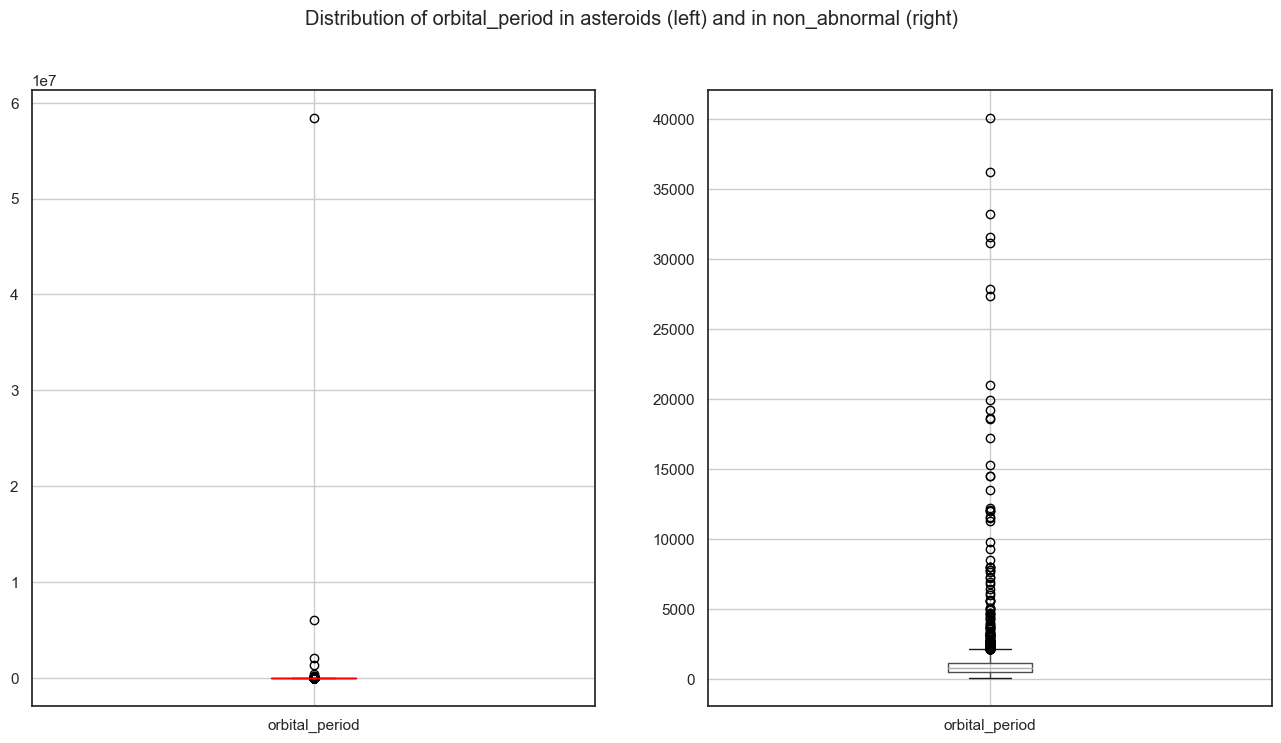

In [532]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8))
asteroids.boxplot(column=['orbital_period'], return_type='axes',color="red", ax=ax1)
non_abnormal.boxplot(column=['orbital_period'], return_type='axes', ax=ax2)
plt.suptitle('Distribution of orbital_period in asteroids (left) and in non_abnormal (right)')
plt.show()

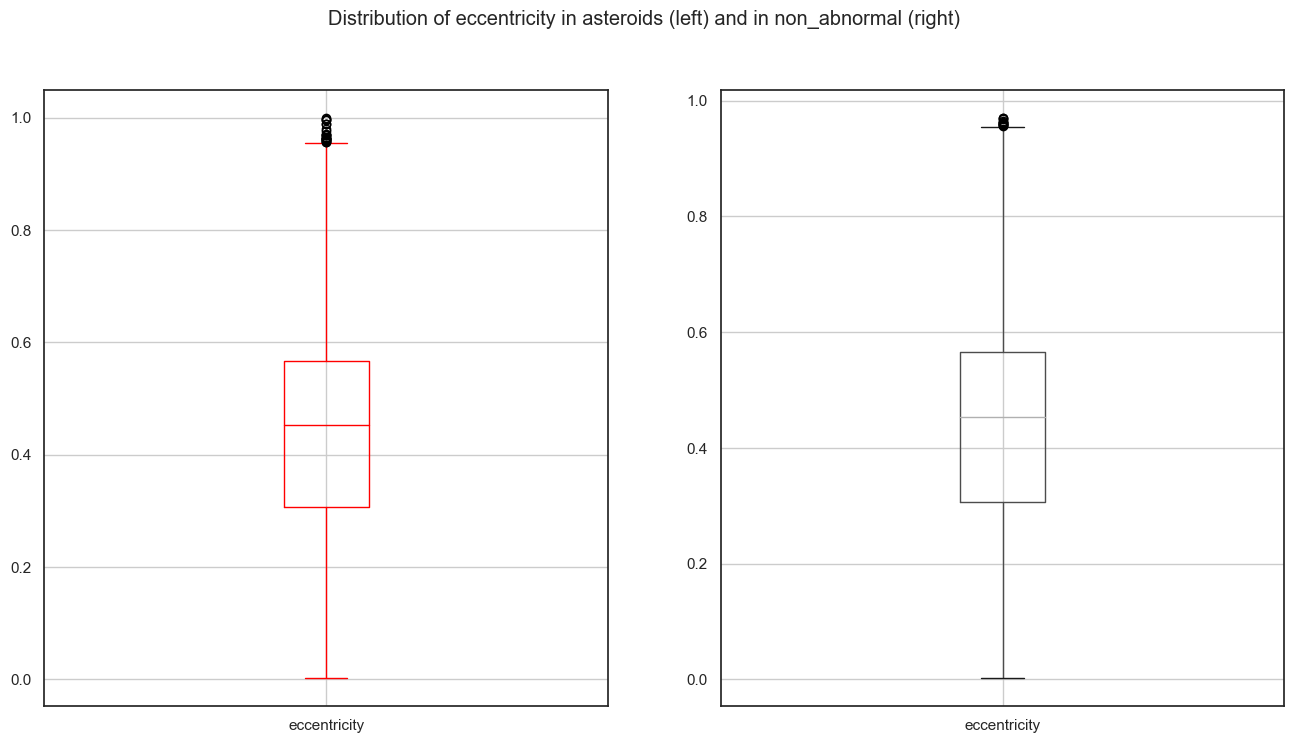

In [533]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8))
asteroids.boxplot(column=['eccentricity'], return_type='axes',color="red", ax=ax1)
non_abnormal.boxplot(column=['eccentricity'], return_type='axes', ax=ax2)
plt.suptitle('Distribution of eccentricity in asteroids (left) and in non_abnormal (right)')
plt.show()

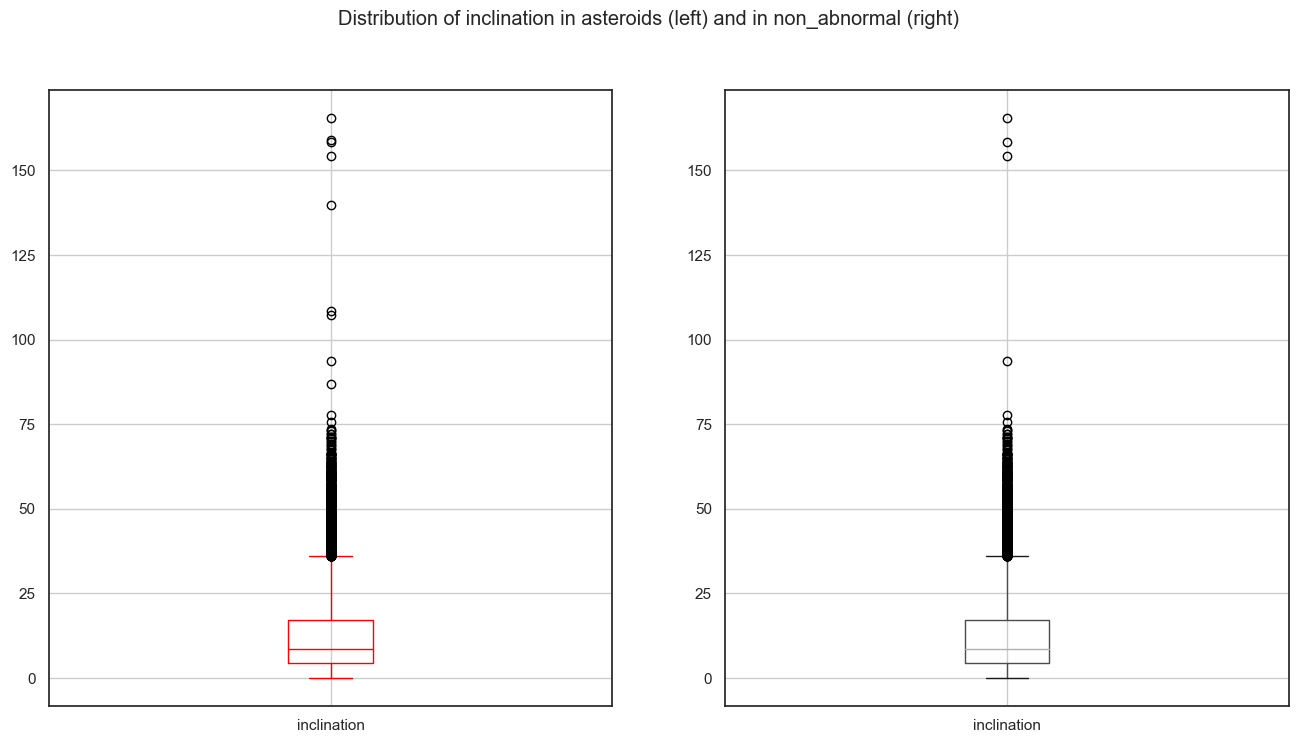

In [534]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8))
asteroids.boxplot(column=['inclination'], return_type='axes',color="red", ax=ax1)
non_abnormal.boxplot(column=['inclination'], return_type='axes', ax=ax2)
plt.suptitle('Distribution of inclination in asteroids (left) and in non_abnormal (right)')
plt.show()

Check the relationship between the orbital period and the semi major axis of the asteroids.

<Axes: title={'center': 'Asteroid orbit period vs. semi-major axis'}, xlabel='orbital_period', ylabel='semi_major_axis'>

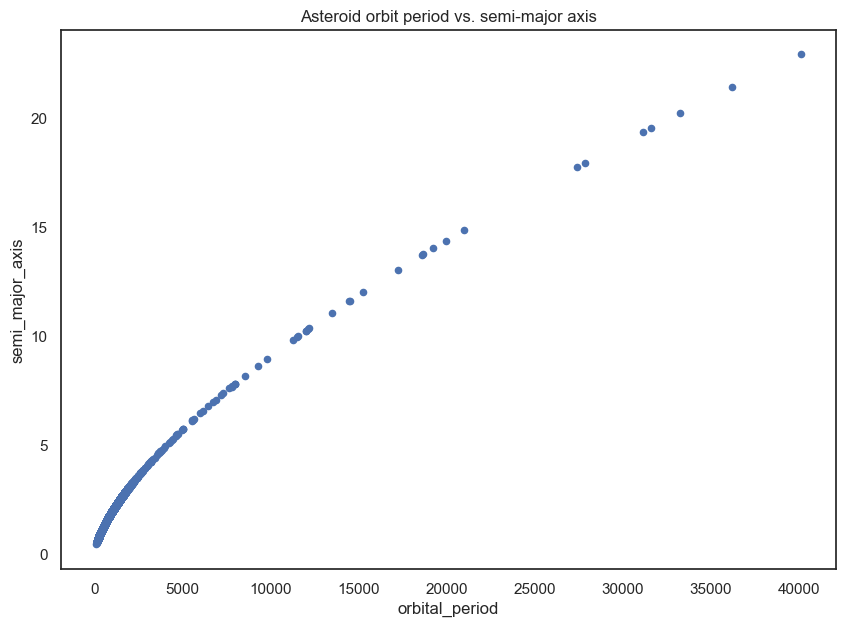

In [535]:
non_abnormal.plot(kind="scatter", x="orbital_period", y="semi_major_axis", title = "Asteroid orbit period vs. semi-major axis")


According to the **Kepler's third law**: The square of the period of a planet's orbit is proportional to the cube of its semimajor axis. 

Check whether the `non_abnormal` dataset meets the Kepler's 3rd law.

In [536]:
non_abnormal['power_orbital_period'] = non_abnormal['orbital_period'] * non_abnormal['orbital_period']

non_abnormal['cube_semi_major_axis'] = non_abnormal['semi_major_axis'] * non_abnormal['semi_major_axis'] * non_abnormal['semi_major_axis']

[Text(0.5, 1.0, 'Square of orbit period vs. Cube of semi-major axis')]

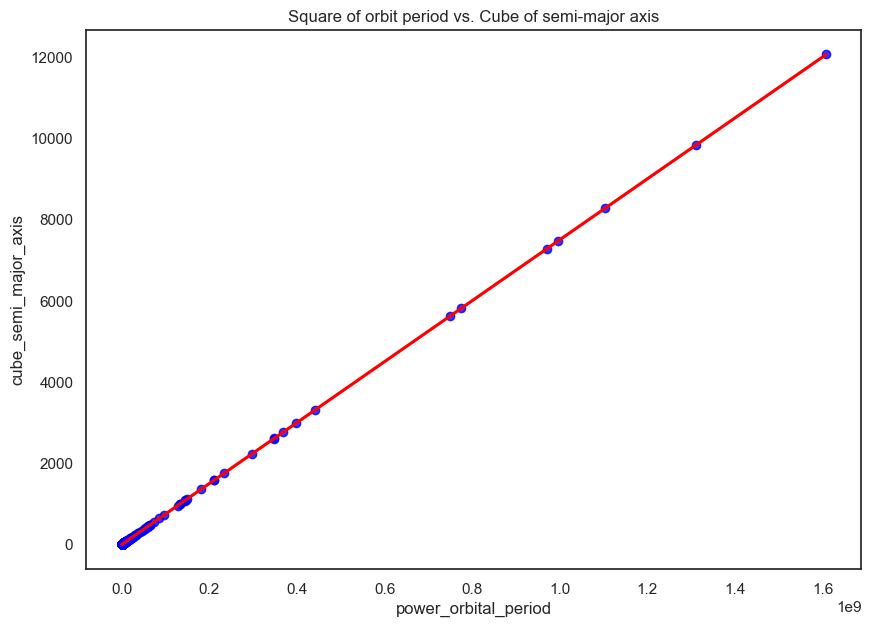

In [537]:
sns.regplot(x = "power_orbital_period",
            y = "cube_semi_major_axis",
            scatter_kws={"color":"blue"},line_kws={"color":"red"},
            data = non_abnormal).set(title='Square of orbit period vs. Cube of semi-major axis')

The `asteroids dataset` meets the Kepler's 3rd law.

Asteroids are grouped in different groups or regions of asteroids. For example, many asteroids are clustered in the main asteroid belt, between the orbits of Mars and Jupiter, but there is also a large group of asteroids called the Jupiter Trojans that share Jupiter's orbit around the Sun. 

Check whether the asteroids exist in the `non_abnormal` dataframe are grouped or not.

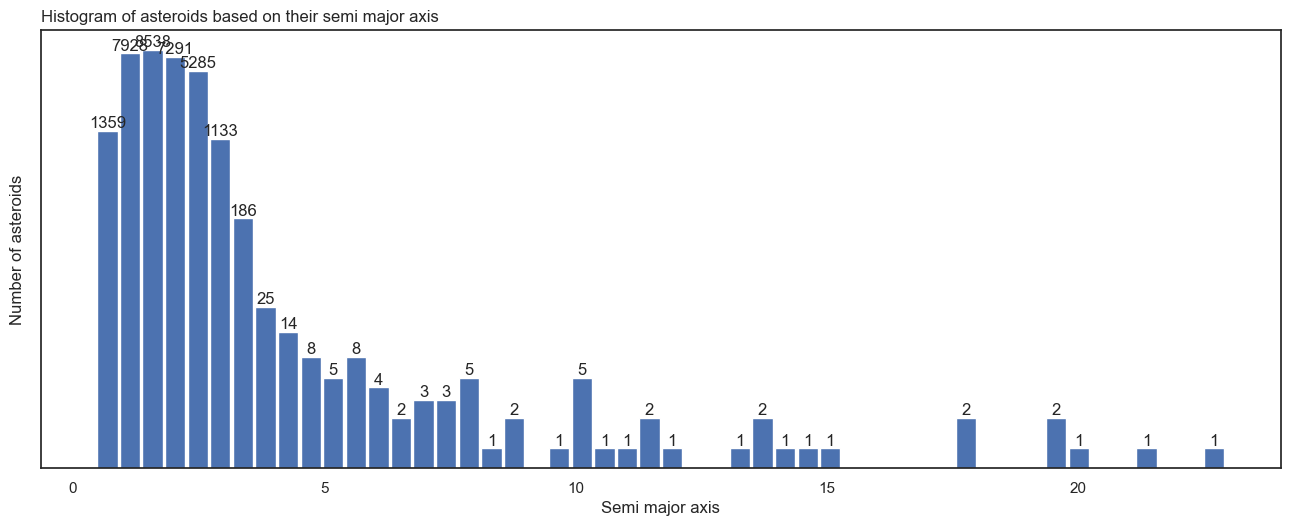

In [538]:
fig = plt.figure(figsize=(16,6))
counts, bins, patches = plt.hist(non_abnormal["semi_major_axis"], bins=50, rwidth=0.9)

# plot values on top of bars
plt.bar_label(patches)

plt.yscale('log')
plt.yticks([])

#plt.xticks(bins)
plt.grid(color='white', lw = 0.5, axis='x')
plt.ylabel("Number of asteroids")
plt.xlabel("Semi major axis")
plt.title('Histogram of asteroids based on their semi major axis', loc = 'left', fontsize = 12)

plt.subplots_adjust(bottom=0.15)
plt.show()

At least **3** groups of asteroids can be identified.

Check the distribution of asteroids in respect of:
- semi major axis vs eccenticity (filter `non_abnormal` dataframe to have only those asteroids with `semi_major_axis` less than 5)
- semi major axis vs inclination (filter `non_abnormal` dataframe to have only those asteroids with `semi_major_axis` less than 3 and `inclination` less than 75)
- semi major axis vs asteroid size (filter `non_abnormal` dataframe to have only those asteroids with `semi_major_axis` less than 3 and `average_diameter` less than 1.5)
- inclination vs eccenticity (filter `non_abnormal` dataframe to have only those asteroids with `inclination` less than 75)

*Filtering of the `non_abnormal` dataframe excluded the outliers for better visualization*

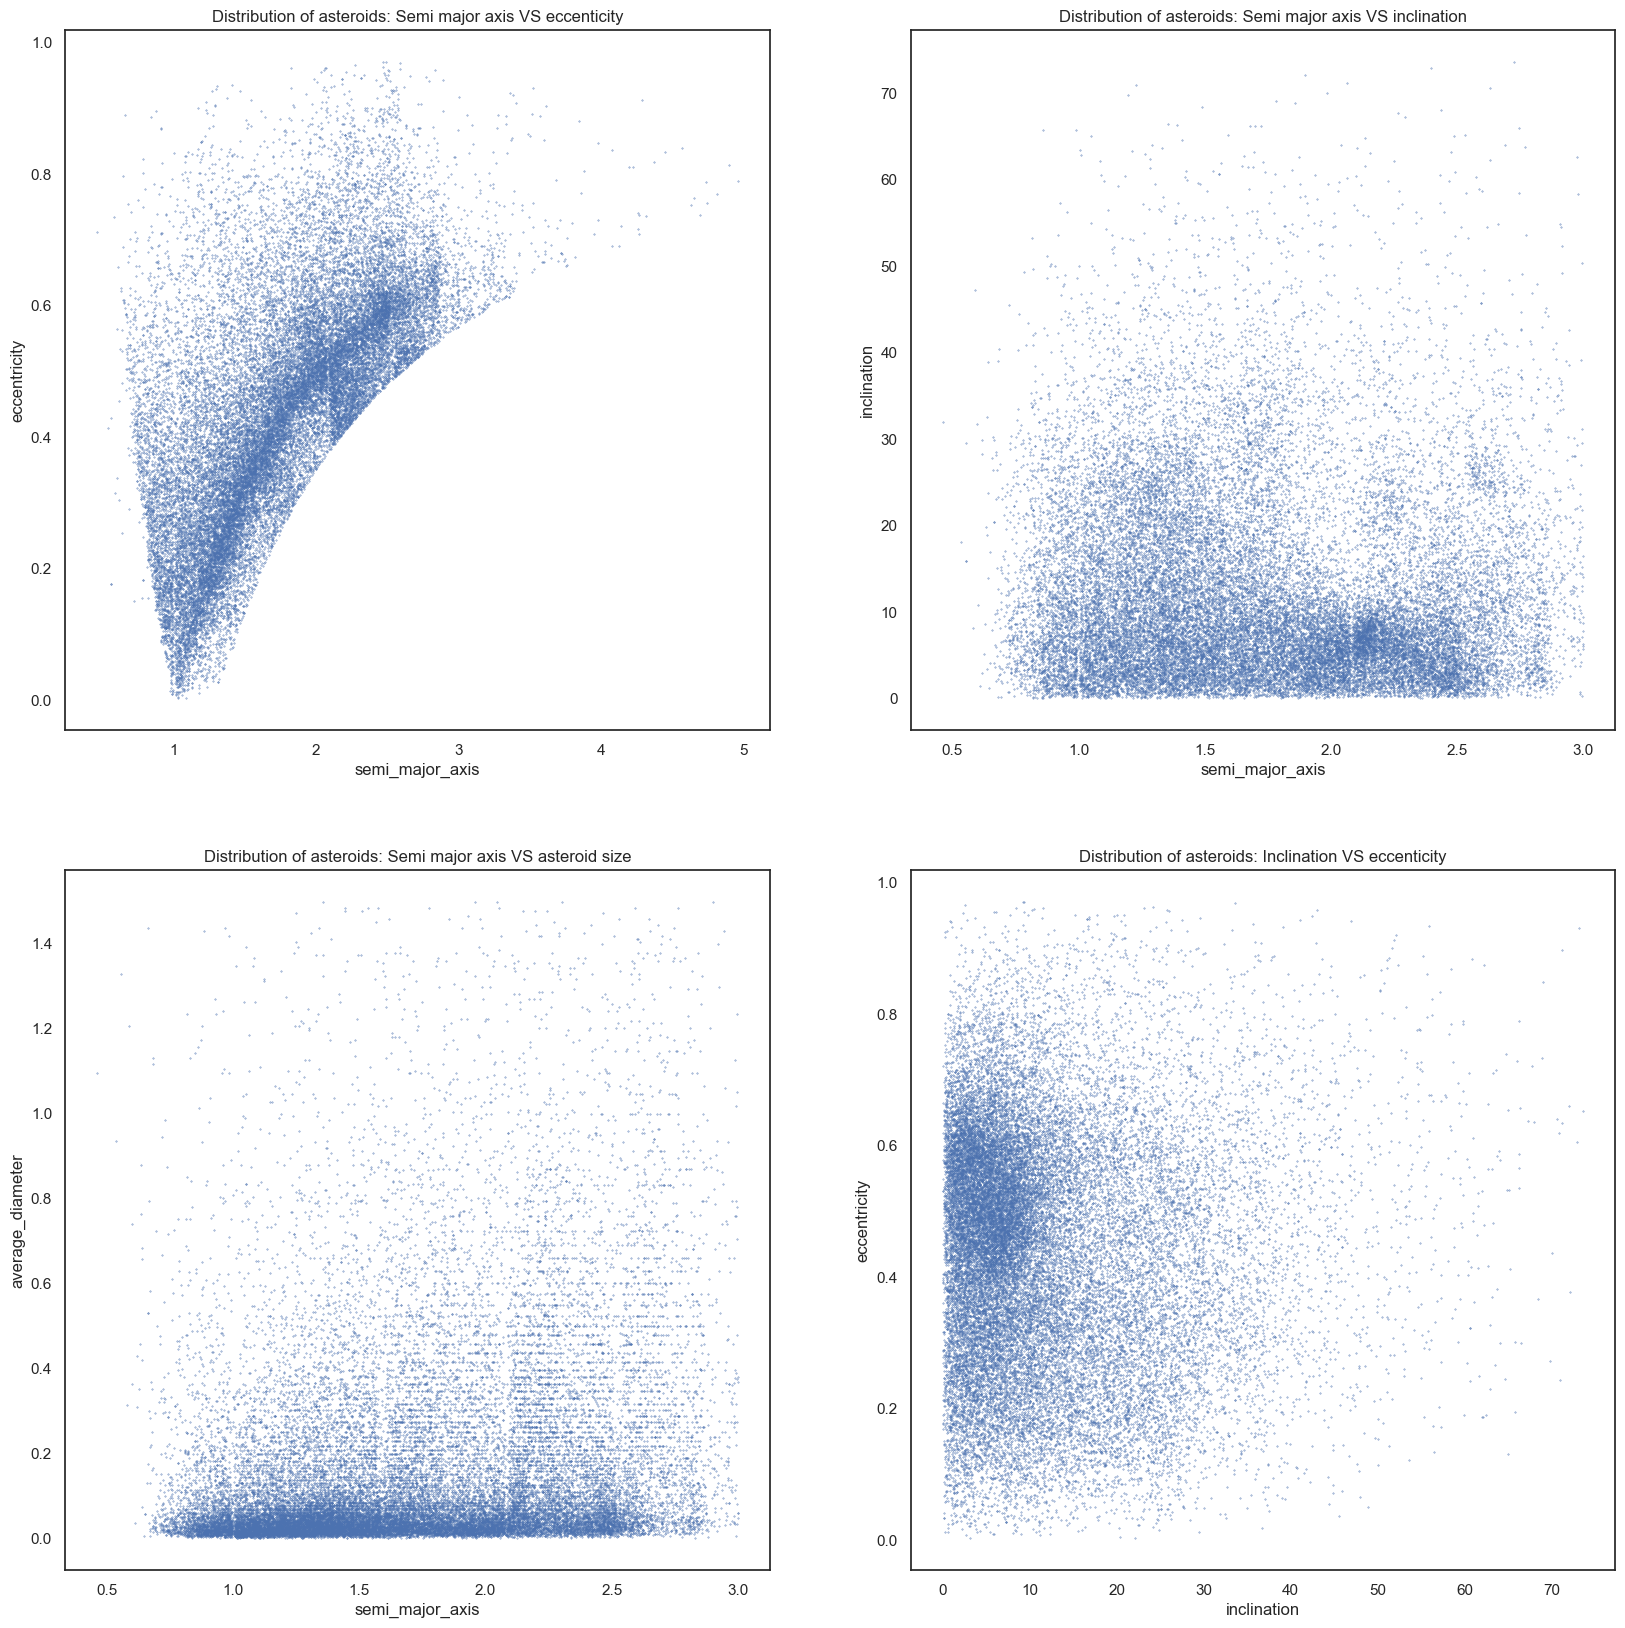

In [539]:
if(asteroids_filename == 'asteroids'):
    size = 8
else:
    size = 0.1
fig, ax = plt.subplots(nrows= 2, ncols=2, figsize=(20,20))

non_abnormal[non_abnormal['semi_major_axis']<5].plot(kind="scatter", x="semi_major_axis", y="eccentricity",  
                s=size, ax=ax[0,0], title='Distribution of asteroids: Semi major axis VS eccenticity')

non_abnormal[(non_abnormal['semi_major_axis']<3) & (non_abnormal['inclination']<75) ].plot(kind="scatter", 
                x="semi_major_axis", y="inclination", s=size, ax=ax[0,1], title='Distribution of asteroids: Semi major axis VS inclination')

non_abnormal[(non_abnormal['semi_major_axis']<3) & (non_abnormal['average_diameter']<1.5)].plot(kind="scatter", 
                x="semi_major_axis", y="average_diameter", s=size,  ax=ax[1,0], title='Distribution of asteroids: Semi major axis VS asteroid size')

non_abnormal[(non_abnormal['inclination']<75)].plot(kind="scatter", x="inclination", y="eccentricity", 
                s=size, ax=ax[1,1], title='Distribution of asteroids: Inclination VS eccenticity')

#plt.suptitle('Distribution of inclination in asteroids (left) and in non_abnormal (right)')
plt.show()

- semi major axis vs size: It is visible that gaps exist at some semi_major_axis values (~1 , ~1.6, ~2.1, ~2.52 approximately)
- semi major axis vs inclination: It is visible that gaps exist at some semi_major_axis values (~1 , ~1.6, ~2.2, ~2.5 approximately)
- semi major axis vs eccentricity: There is a strong correlation between them
- inclination vs eccentricity: There is not a strong correlation.

Check how the `absolute_magnitude_h` feature is distributed in terms of `semi_major_axis` and `orbital_period` features.

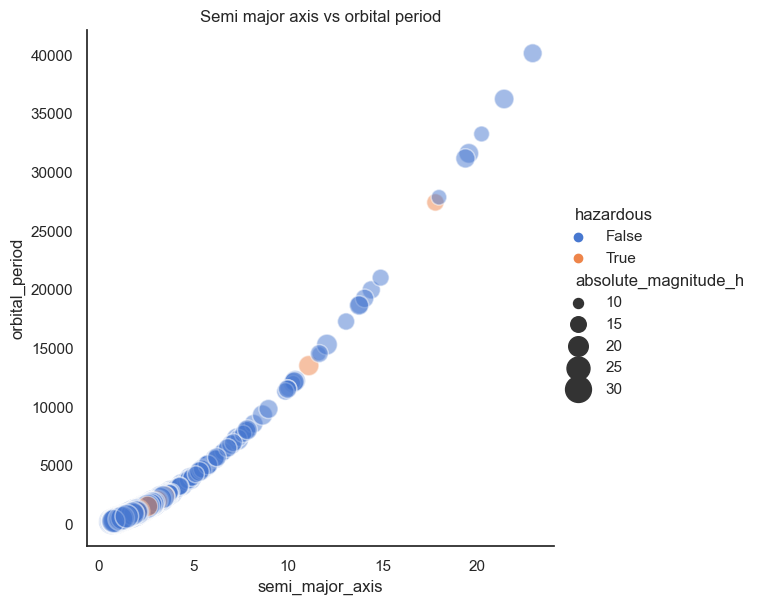

In [540]:
sns.set_theme(style="white")

sns.relplot(x="semi_major_axis", y="orbital_period",  hue="hazardous", size="absolute_magnitude_h",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=non_abnormal).set(title='Semi major axis vs orbital period')
plt.show()

Check whether `eccentricity` and `inclination` features can be used to classify an asteroid as a potential hazardous one.

In [541]:
fig = px.scatter(asteroids, x="eccentricity", y="inclination",
	         size="absolute_magnitude_h", color="hazardous",
                  log_x=True, size_max=6, title="Distribution of hazardous / non hazardous asteroids")

fig.update_layout(
    title="Interactive - Distribution of hazardous / non hazardous asteroids",
    xaxis_title="Eccentricity",
    yaxis_title="Inclination",
    legend_title="Hazardous",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="Blue"
    )
)

fig.show()

It seams that the vast majority of hazardous asteroids are depicted at the right bottom of the above figure. Thus the `inclination`and `eccentricity` features can be used by a clasifier that classifies an asteroid as a potential hazardous asteroid based on its orbital information.

### Analysis of close aproach data

Apart from asteroid name, size and whether it is hazardous or not, the `close_approach_data` dataframe contains information regarding the planets (`orbiting_body`) the asteroids appoach, the approaching dates (`close_approach_date`), the distance (`miss_distance`) from the planets and the asteroid's velocity (`relative_velocity`).

Check the format and the size of the `close_approach_data` dataframe.

In [542]:
close_approach_data.head(10)

hazardous close_approach_date  miss_distance orbiting_body  \
name                                                                            
333311 (2001 MR3)      False          1910-06-21   4.691516e+07         Earth   
333311 (2001 MR3)      False          1921-07-23   6.856567e+07         Earth   
333311 (2001 MR3)      False          1930-05-05   2.606520e+08         Juptr   
333311 (2001 MR3)      False          1950-06-02   7.078425e+07         Earth   
333311 (2001 MR3)      False          1961-07-08   5.092106e+07         Earth   
333311 (2001 MR3)      False          1977-07-25   2.722770e+08         Juptr   
333311 (2001 MR3)      False          2001-06-30   4.181479e+07         Earth   
333311 (2001 MR3)      False          2014-05-19   2.987633e+08         Juptr   
333311 (2001 MR3)      False          2024-10-04   2.911691e+08         Juptr   
333311 (2001 MR3)      False          2041-06-21   4.955280e+07         Earth   

                   relative_velocity  average_diameter  
name                                                    
333311 (2001 MR3)           2.739309           0.68162  
333311 (2001 MR3)           1.344208           0.68162  
333311 (2001 MR3)           1.591018           0.68162  
333311 (2001 MR3)           2.163728           0.68162  
333311 (2001 MR3)           2.765331           0.68162  
333311 (2001 MR3)           1.516158           0.68162  
333311 (2001 MR3)           2.764182           0.68162  
333311 (2001 MR3)           1.231233           0.68162  
333311 (2001 MR3)           1.371997           0.68162  
333311 (2001 MR3)           2.715806           0.68162

In [543]:
close_approach_data.shape

(14027, 6)

Not all asteroids that exists in the `asteroids` dataframe have close approach data. 

In [544]:
len(close_approach_data.index.unique())

273

In [545]:
close_approach_data['close_approach_date'].min()

'1899-12-30'

In [546]:
close_approach_data['close_approach_date'].max()

'2200-12-28'

Only **273** asteroids have close approach data between **1899-12-30** untill **2200-12-28**.

In `close_appoach_data` dataframe, each asteroid might have several approaches to serveral orbiting bodies. 

In [547]:
pd.crosstab(close_approach_data.index, close_approach_data['orbiting_body'])

orbiting_body       Earth  Juptr  Mars  Merc  Moon  Venus
row_0                                                    
(1983 LC)              24      9     3     0     0      8
(1991 TF3)             20      1     0     0     0      0
(1995 FJ)             104      0     0     0     0     15
(1997 GL3)             37     12     1     0     1      7
(1998 FJ74)             9      0     1     0     0      0
...                   ...    ...   ...   ...   ...    ...
(2022 DD5)             12      0     0     0     0      0
(2022 DO)               1      0     1     0     0      0
(2022 RH23)             8      0     2     0     0      0
333311 (2001 MR3)      12      7     1     0     0      0
350872 (2002 PG43)     13      0     4     0     0      0

[273 rows x 6 columns]

For example, the *(1983 LC)* asteroid approaches *Earth* 24 times, *Jupiter* 9 time, *Mars* 3 times and *Venus* 8 times between **1899-12-30** untill **2200-12-28**.





The following chart depicts the number of approaching data that exists in `close_approach_data` dataframe per orbiting body.

In [548]:
planets = close_approach_data['orbiting_body'].value_counts()
planets

Earth    11387
Venus     1436
Juptr      524
Merc       403
Mars       245
Moon        32
Name: orbiting_body, dtype: int64

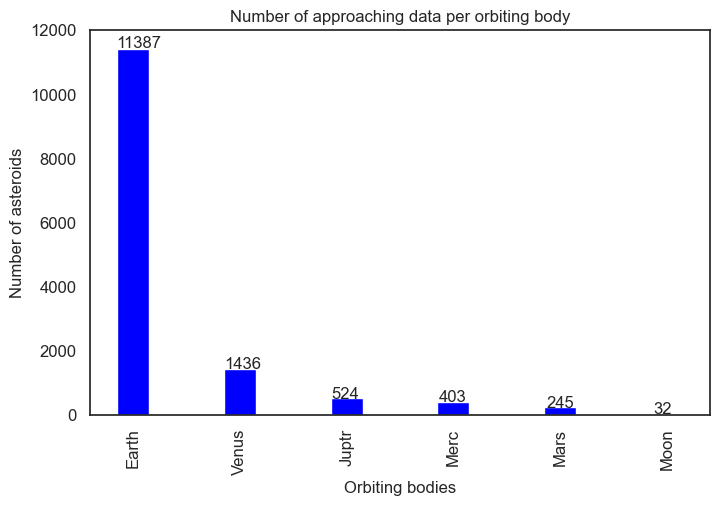

In [549]:
ax = planets.plot(kind="bar", figsize=(8, 5), fontsize=12, color="blue", width=0.3)
# customize the axes and title
ax.set_ylim((0,12000))
ax.set_xlabel("Orbiting bodies", fontsize=12)
ax.set_ylabel("Number of asteroids", fontsize=12)
ax.set_title("Number of approaching data per orbiting body", fontsize=12);

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

The `major_impact` function selects for each asteroid and for each orbiting body (that the asteroid in question approaches) its approaching information that has the minimum aproaching distance and thus the major potential impact in case of impact event.

The `major_impact` function has two parameters:
- `asteroids_close_approach_data`: the `close_approach_data` dataframe, and,
- `today` : if *Yes*, it takes into account only those entries that have close_approach_date >= today, otherwise all entries

In [550]:
from datetime import date
def major_impact(asteroids_close_approach_data,today = None):
    mitsos = pd.DataFrame()
    if (today == "Yes"):
        asteroids_close_approach_data = asteroids_close_approach_data[asteroids_close_approach_data.close_approach_date >= str(date.today())]
    unique_asteroid = asteroids_close_approach_data.index.unique()
    for asteroid in unique_asteroid:
        
        asteroid_close_data = asteroids_close_approach_data[asteroids_close_approach_data.index == asteroid]
        #print(asteroid)
        
        unique_orbiding_body = asteroid_close_data.orbiting_body.unique()
        for row in unique_orbiding_body:
            close_data = asteroid_close_data[asteroid_close_data["orbiting_body"] == row]
            #print(close_data)
            cs = close_data[close_data.miss_distance == close_data["miss_distance"].min()]
            #print(cs)
            #mitsos = mitsos.append(cs)
            mitsos = pd.concat([mitsos,cs])
    return mitsos

Compute the close approach data with the potential major impact in case of impact event from  **1899-12-30** untill **2200-12-28**

In [551]:
mitsos = major_impact(close_approach_data)

Check the format and the shape of `mitsos` dataframe

In [552]:
mitsos.head(5)

hazardous close_approach_date  miss_distance orbiting_body  \
name                                                                            
333311 (2001 MR3)      False          2001-06-30   4.181479e+07         Earth   
333311 (2001 MR3)      False          2156-01-19   2.600926e+08         Juptr   
333311 (2001 MR3)      False          2114-01-29   6.520841e+06          Mars   
(1983 LC)               True          2156-07-27   5.082005e+06         Venus   
(1983 LC)               True          1908-04-09   9.650917e+06          Mars   

                   relative_velocity  average_diameter  
name                                                    
333311 (2001 MR3)           2.764182          0.681620  
333311 (2001 MR3)           1.503610          0.681620  
333311 (2001 MR3)           7.380369          0.681620  
(1983 LC)                  11.554961          0.554042  
(1983 LC)                  16.308806          0.554042

In [553]:
mitsos.shape

(525, 6)

Thus, **525** close approaches are considered to be of major impact.

From the **525** close approaches, the **269** are close to **Earth** approaches.

In [554]:
earth = mitsos[mitsos["orbiting_body"]=="Earth"]
print(earth.shape)


(269, 6)


The five most close to Earth approaches (with the major impact)  from 1899-12-30 untill 2200-12-28 and in terms of the minimum distance from the Earth are: 

In [555]:
earth.sort_values(by = "miss_distance", ascending = True).head(5)

hazardous close_approach_date  miss_distance orbiting_body  \
name                                                                      
(2020 SO)        False          2020-12-01   50410.458007         Earth   
(2002 JE9)        True          1971-04-11  267511.180410         Earth   
(2021 RJ1)       False          2021-09-02  378558.546979         Earth   
(2004 XP14)       True          2006-07-03  432438.418948         Earth   
(2006 RJ1)       False          1955-12-22  467322.667540         Earth   

             relative_velocity  average_diameter  
name                                              
(2020 SO)             3.905311          0.010694  
(2002 JE9)           13.216695          0.225706  
(2021 RJ1)           14.144786          0.013563  
(2004 XP14)          17.406756          0.566947  
(2006 RJ1)            9.148872          0.151197

The **(2020 SO)** asteroid came closest (distance = 50410.45 KM)  to Earth at 2020-12-01. It is classified as Non hazardous asteroid.


The next closest to Earth asteroid is the **(2002 JE9)** asteroid that came close to Earth at distance = 267511.18 KM at 1971-04-11. 

It is a very small asteroid whose orbit crosses the orbit of Earth. NASA JPL has classified 2002 JE9 as a "Potentially Hazardous Asteroid" due to its predicted close pass(es) with Earth. (Reference: https://www.spacereference.org/asteroid/612358-2002-je9)

Compute the close approach data with the potential major impact in case of impact event from **now** untill **2200-12-28**

In [556]:
mitsos_future = major_impact(close_approach_data,"Yes")

Check the format and the shape of `mitsos_future` dataframe

In [557]:
mitsos_future.head(5)

hazardous close_approach_date  miss_distance orbiting_body  \
name                                                                            
333311 (2001 MR3)      False          2156-01-19   2.600926e+08         Juptr   
333311 (2001 MR3)      False          2132-07-01   4.183327e+07         Earth   
333311 (2001 MR3)      False          2114-01-29   6.520841e+06          Mars   
(1983 LC)               True          2097-06-26   5.128899e+06         Earth   
(1983 LC)               True          2027-11-26   1.407393e+08         Juptr   

                   relative_velocity  average_diameter  
name                                                    
333311 (2001 MR3)           1.503610          0.681620  
333311 (2001 MR3)           2.690912          0.681620  
333311 (2001 MR3)           7.380369          0.681620  
(1983 LC)                  18.854480          0.554042  
(1983 LC)                   5.059741          0.554042

In [558]:
print(mitsos_future.shape)

(466, 6)


Thus, **466** close approaches are considered to be of major impact in the near future.

From the **466** close approaches in near future, the **242** are close to **Earth** approaches.

In [559]:
earth_future = mitsos_future[mitsos_future["orbiting_body"]=="Earth"]
print(earth_future.shape)

(242, 6)


The five most close to Earth approaches (with the major impact) in the near future and in terms of the minimum distance from the Earth are: 

In [560]:
earth_future.sort_values(by = "miss_distance", ascending = True).head(5)

hazardous close_approach_date  miss_distance orbiting_body  \
name                                                                      
(1997 GL3)        True          2153-09-21   7.761332e+05         Earth   
(2011 WL2)        True          2077-10-25   8.507468e+05         Earth   
(2006 GB)         True          2081-03-22   1.480923e+06         Earth   
(2007 UY1)       False          2123-10-02   1.842632e+06         Earth   
(2000 WP19)      False          2121-11-17   1.873540e+06         Earth   

             relative_velocity  average_diameter  
name                                              
(1997 GL3)           24.987709          0.639061  
(2011 WL2)           11.500165          0.311561  
(2006 GB)             7.090734          0.367741  
(2007 UY1)            5.765666          0.103167  
(2000 WP19)           8.479132          0.124035

The **(1997 GL3)** asteroid will come closest (distance = 776133 KM) to Earth at 2153-09-21. It is classified as hazardous asteroid.

The five most close to Earth approaches (with the major impact) in terms of time in the near future are: 

In [561]:
earth_future.sort_values(by = "close_approach_date", ascending = True).head(5)

hazardous close_approach_date  miss_distance orbiting_body  \
name                                                                      
(2017 OD20)      False          2023-07-29   3.650285e+07         Earth   
(2015 BF4)       False          2023-12-14   2.998166e+07         Earth   
(2017 YZ1)        True          2024-07-03   1.067043e+07         Earth   
(2008 CZ21)      False          2024-09-22   4.595728e+07         Earth   
(2019 BA1)       False          2025-01-25   3.821746e+07         Earth   

             relative_velocity  average_diameter  
name                                              
(2017 OD20)           2.281638          0.125760  
(2015 BF4)            3.914925          0.341619  
(2017 YZ1)           15.207667          0.352811  
(2008 CZ21)           8.572309          0.357720  
(2019 BA1)           19.235998          0.156871

At 2023-07-29, the **(2017 OD20)** asteroid will come close to Earth at distance of 36502850 KM

The following figures present the statistical information for `miss_distance` and `relative_velocity` features in `close_approach_data` dataframe.

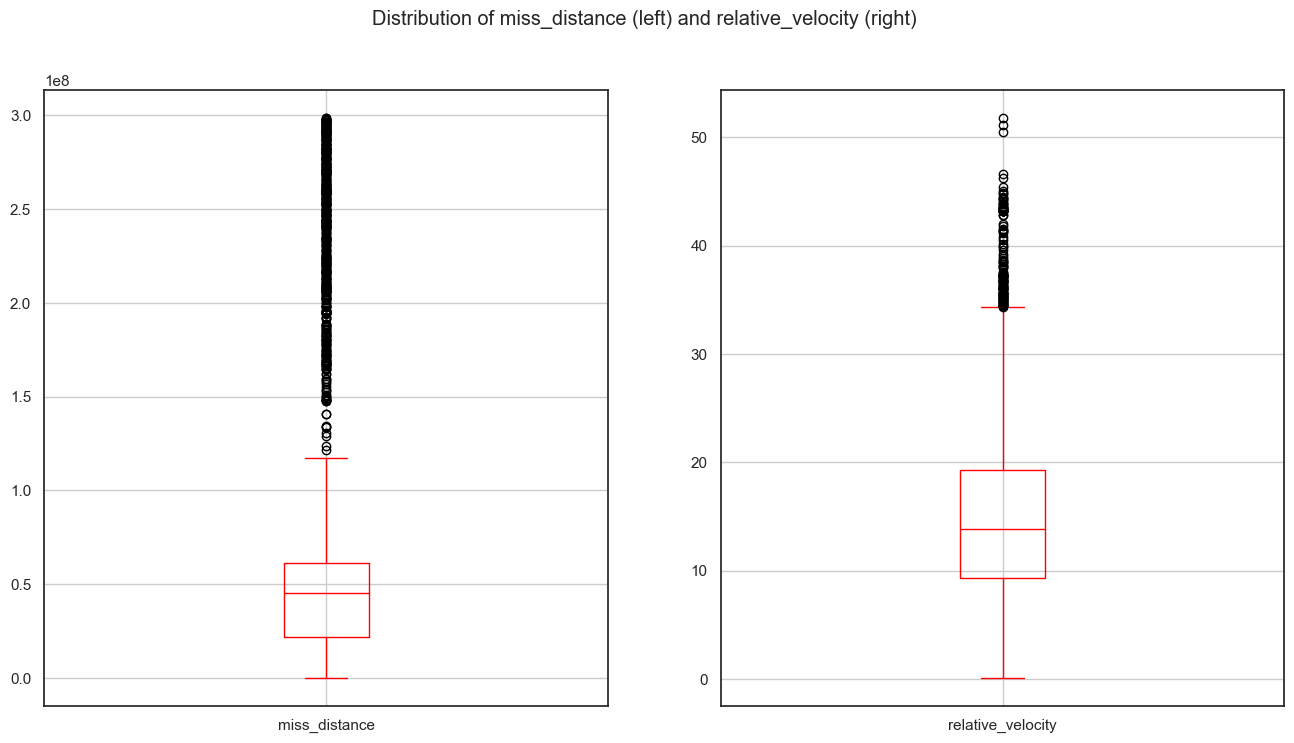

In [562]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8))
close_approach_data.boxplot(column=['miss_distance'], return_type='axes',color="red", ax=ax1)
close_approach_data.boxplot(column=['relative_velocity'], return_type='axes',color="red", ax=ax2)
plt.suptitle('Distribution of miss_distance (left) and relative_velocity (right)')
plt.show()

Check the relation between the `average_diameter` and the `relative_velocity` features of the `earth` dataframe.

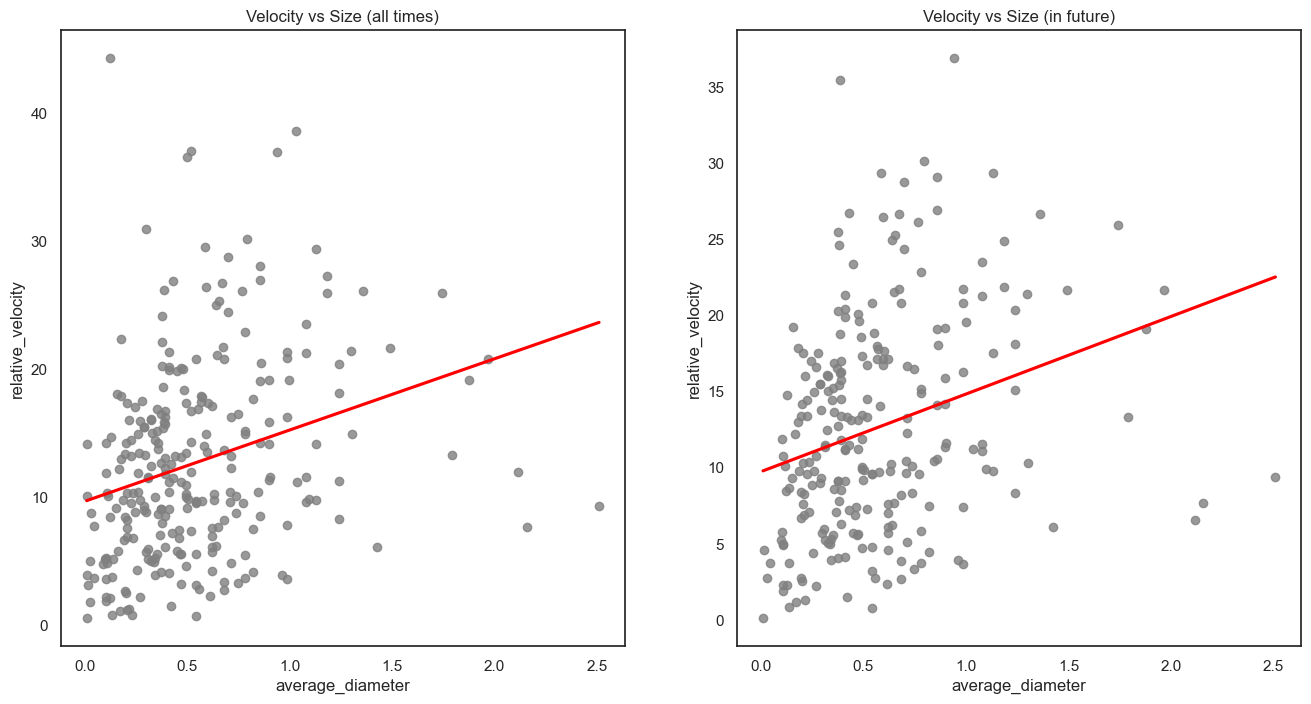

In [563]:
fig, ax =plt.subplots(1,2, figsize=(16,8))
sns.regplot(data = earth, x="average_diameter", y="relative_velocity",ci=None, scatter_kws={"color":"grey"},line_kws={"color":"red"}, ax=ax[0]).set(title='Velocity vs Size (all times)')

#sns.regplot(earth["average_diameter"], earth["relative_velocity"], ci=None,scatter_kws={"color":"grey"},line_kws={"color":"red"}, ax=ax[0]).set(title='Near Earth asteroids - Velocity vs
sns.regplot(data = earth_future, x="average_diameter", y="relative_velocity", ci=None,scatter_kws={"color":"grey"},line_kws={"color":"red"}, ax=ax[1]).set(title='Velocity vs Size (in future)')
fig.show()

The left figure presents the relation  between the `average_diameter` and the `relative_velocity` features from 1899-12-30 untill 2200-12-28 while the right figure presents the same relation in future.

The red line corresponds to the regression line computed by the regression model `relative_velocity ~ average_diameter`

Check the relation between the `average_diameter` and the `miss_distance` features of the `earth` dataframe.

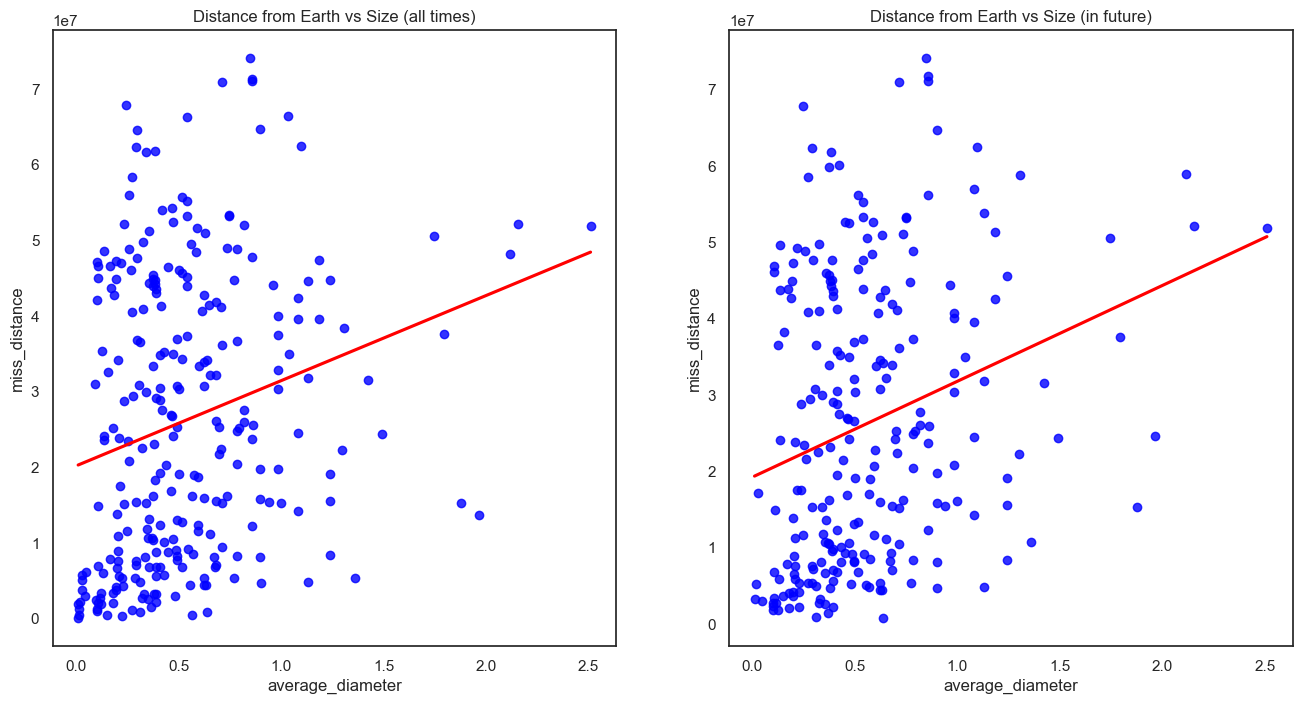

In [564]:
fig, ax =plt.subplots(1,2, figsize=(16,8))
sns.regplot(data = earth, x = "average_diameter", y = "miss_distance",ci=None,scatter_kws={"color":"blue"},line_kws={"color":"red"}, ax=ax[0]).set(title='Distance from Earth vs Size (all times)')

#sns.regplot(earth["average_diameter"], earth["relative_velocity"], ci=None,scatter_kws={"color":"grey"},line_kws={"color":"red"}, ax=ax[0]).set(title='Near Earth asteroids - Velocity vs
sns.regplot(data = earth_future, x = "average_diameter", y = "miss_distance", ci=None,scatter_kws={"color":"blue"},line_kws={"color":"red"}, ax=ax[1]).set(title='Distance from Earth vs Size (in future)')
fig.show()

The left figure presents the relation  between the `average_diameter` and the `miss_distance` features from 1899-12-30 untill 2200-12-28 while the right figure presents the same relation in future.

The red line corresponds to the regression line computed by the regression model `miss_distance ~ average_diameter`

Check the relation between the `miss_distance` and the `relative_velocity` features of the `earth` dataframe.

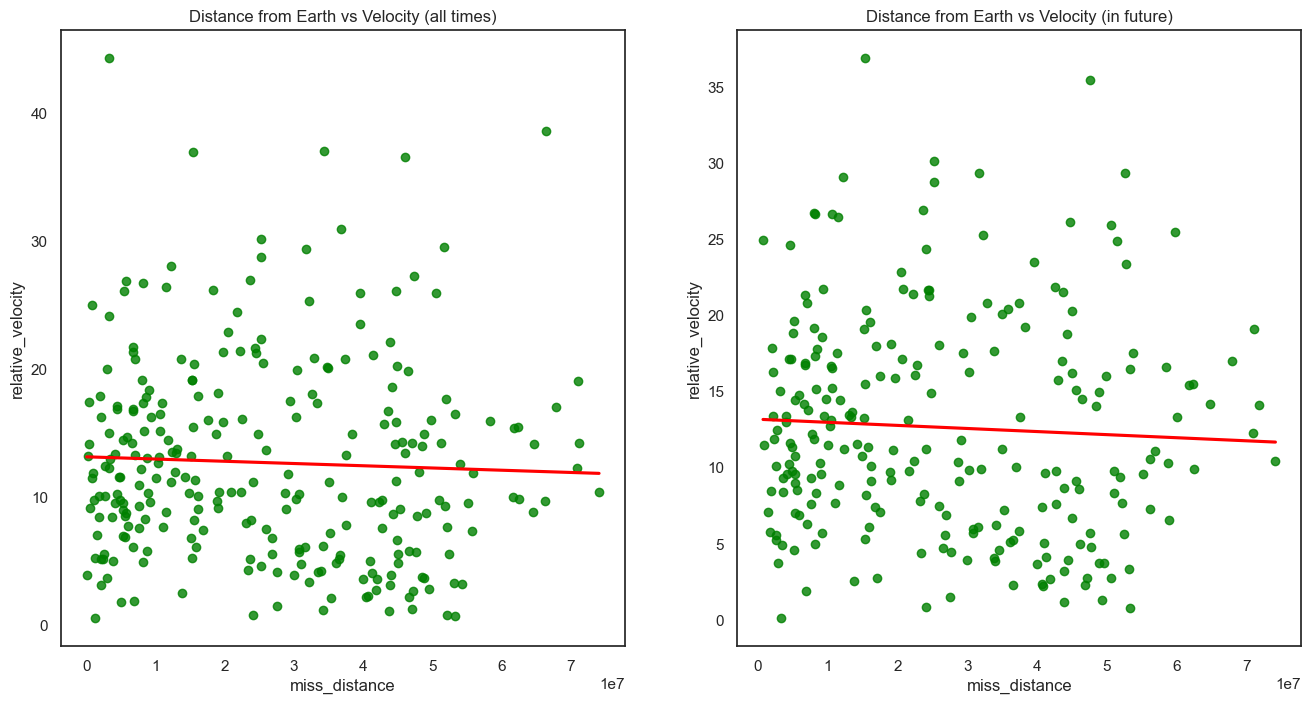

In [565]:
fig, ax =plt.subplots(1,2, figsize=(16,8))
sns.regplot(data = earth, x = "miss_distance", y = "relative_velocity",ci=None,scatter_kws={"color":"green"},line_kws={"color":"red"}, ax=ax[0]).set(title='Distance from Earth vs Velocity (all times)')

#sns.regplot(earth["average_diameter"], earth["relative_velocity"], ci=None,scatter_kws={"color":"grey"},line_kws={"color":"red"}, ax=ax[0]).set(title='Near Earth asteroids - Velocity vs
sns.regplot(data = earth_future, x = "miss_distance", y = "relative_velocity", ci=None,scatter_kws={"color":"green"},line_kws={"color":"red"}, ax=ax[1]).set(title='Distance from Earth vs Velocity (in future)')
fig.show()

The left figure presents the relation  between the `miss_distance` and the `relative_velocity` features from 1899-12-30 untill 2200-12-28 while the right figure presents the same relation in future.

The red line corresponds to the regression line computed by the regression model `relative_velocity ~ miss_distance`

Check the correlation between `miss_distance` and `relative_velocity` features of the `earth_future` dataframe via a **interactive** diagram

In [566]:
source = ColumnDataSource(earth_future)

dates = sorted(earth_future["close_approach_date"].unique())

columns = [
    TableColumn(field="close_approach_date", title="close_approach_date",
                editor=SelectEditor(options=dates),
                formatter=StringFormatter(font_style="bold")),
]
data_table = DataTable(source=source, columns=columns, editable=True, width=800,
                       index_position=-1, index_header="row index", index_width=60)

p = figure(width=800, height=500, tools="pan,wheel_zoom,xbox_select,reset", active_drag="xbox_select")

velocity = p.circle(x="miss_distance", y="relative_velocity", fill_color="#ff4f00", size=8, alpha=0.5, source=source)
diameter = p.circle(x="miss_distance", y="average_diameter", fill_color="#8f00ff", size=8, alpha=0.5, source=source)

tooltips = []
star_velocity = HoverTool(renderers=[velocity], tooltips=tooltips + [("name", "@name"),("date", "@close_approach_date"),("velocity", "@relative_velocity"),("miss", "@miss_distance"),("orbit", "@orbiting_body")])
star_diameter = HoverTool(renderers=[diameter], tooltips=tooltips + [("name", "@name"),("date", "@close_approach_date"),("velocity", "@relative_velocity"),("miss", "@miss_distance"),("orbit", "@orbiting_body")])

p.add_tools(star_velocity,star_diameter)
p.xaxis.axis_label = 'Distance from Earth'
p.yaxis.axis_label = 'Velocity'
p.title = 'Interactive diagram - Distance from Earth vs Velocity (in future)'

output_notebook()
show(p)

Loading BokehJS ...

The following scatterplot depicts the close approaches with the major potential impact(`mitsos` dataframe) per orbiting body and hazardous indication.

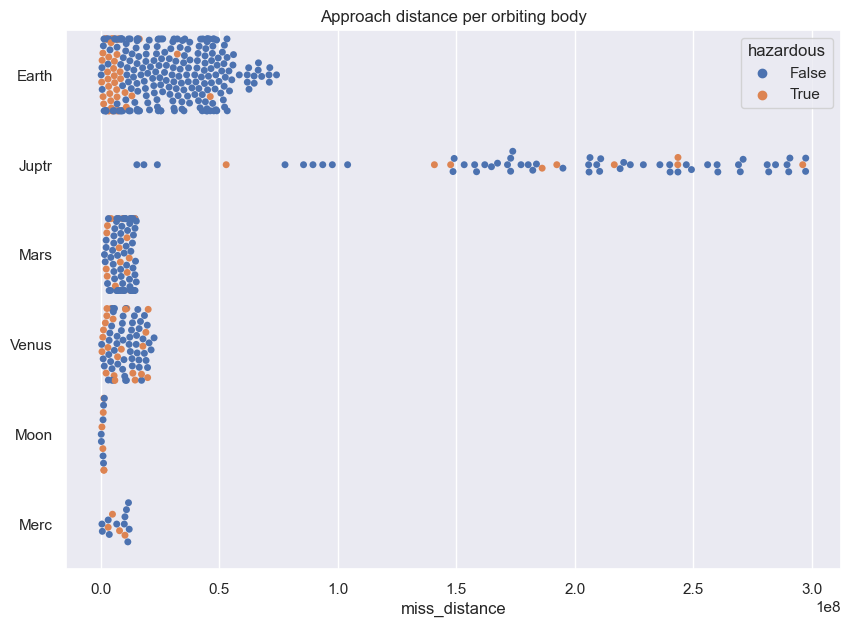

In [567]:
sns.set_theme(style="whitegrid", palette="muted")

sns.set(rc={'figure.figsize':(10,7)})
ax = sns.swarmplot(data=mitsos, x="miss_distance", y="orbiting_body", hue="hazardous")
ax.set(ylabel="",title = "Approach distance per orbiting body")

plt.show()

The pattern of the approach distances to jupiter is different from the rest. 

The following **interactive** figure presents the relation between relative velocity and miss distance per size and hazardous indication in the close approaches with the major potential impact(`mitsos` dataframe).

In [568]:
fig = px.scatter(mitsos, x="relative_velocity", y="miss_distance",
	         size="average_diameter", color="hazardous",
                 hover_name=mitsos.index, log_x=True, size_max=60)
fig.update_layout(
    title="Interactive - Relative velocity vs miss distance per size and hazardous indication",
    xaxis_title="relative_velocity",
    yaxis_title="miss_distance",
    legend_title="Hazardous",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="Blue"
    )
)
fig.show()

### Analysis of Correlations

Check whether different asteroids features are correlated across all asteroids.

Text(0.5, 1.0, 'Asteroids features correlations')

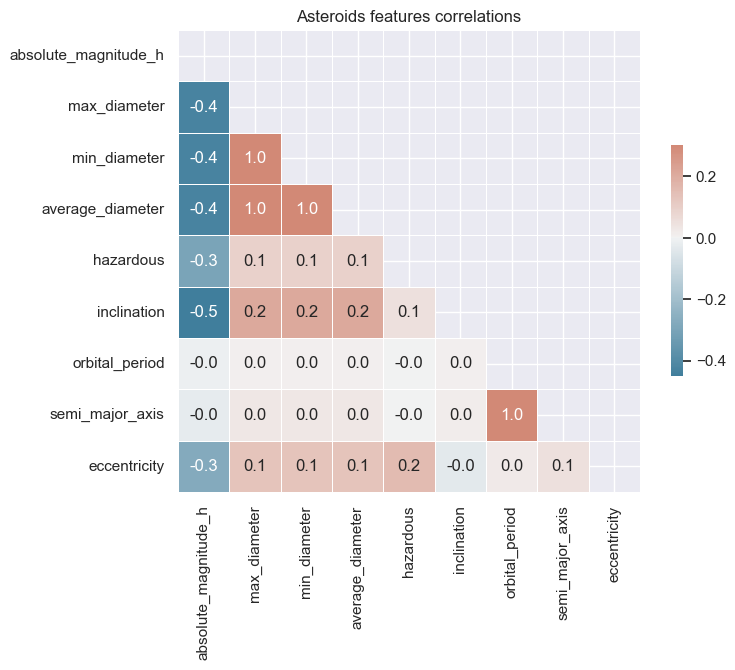

In [569]:
sns.set_theme(style="white")
sns.set(font_scale = 1)

# Compute the correlation matrix
corr = asteroids.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, fmt=".1f")
ax.set_title('Asteroids features correlations')

As expected the maximum, minimum and average diameter features are strongly correlated. Apart from that, the correlations among asteroid features are very weak.

Check whether different features in `close_approach_data`are correlated across all asteroids.

Text(0.5, 1.0, 'Correlations of Asteroids approaching data features')

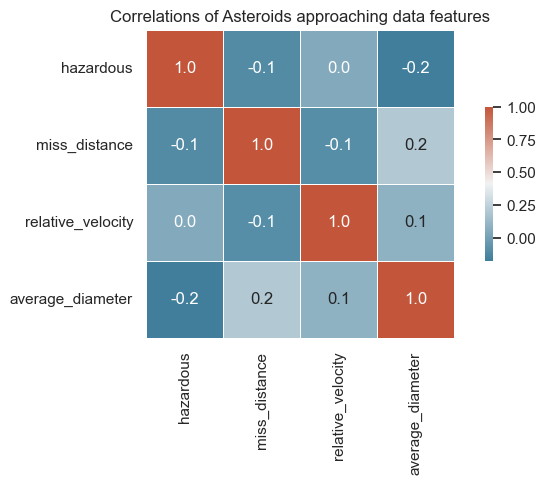

In [570]:
sns.set_theme(style="white")
corrmat = close_approach_data.corr()
f, ax = plt.subplots(figsize = (8, 4))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corrmat, vmax = 1, square = True, linewidths=.5, cmap=cmap, cbar_kws={"shrink": .5},annot=True, fmt=".1f")
ax.set_title('Correlations of Asteroids approaching data features')

The correlations among the features of the `close_apprach_data` are weak.

# Task 3 - Discussion and Conclusion

In this assignment I looked at the analysis of the asteroids, their physical information (focusing in magnitude and size), their classification as potentially hazardous (in case of impact event), their orbital data (focusing on semi major axis, inclination and eccentricity) and the data concerning asteroids' approaches to their orbiting bodies especially to Earth (focusing in miss distance and approaching velocity).
The analysis confirmed that the relation between orbital period and semi major axis follows the Kepler's 3rd law, the asteroids are grouping in some clusters (like asteroid belt, Jupiter Trojan etc.) and the inclination and eccentricity features can be used by a classifier to classify an asteroid as a potential hazardous asteroid.

Three was the challenges of using the NeoWs (Near Earth Object Web Service) API. The first is that there is a limit on the number of API requests you can make by using a particular API key. The default hourly limit is 1,000 requests per hour. During the development of the data collection task and while trying to acquire 1602 pages of asteroid data, the limit was sometimes reached and that led to temporarily blocking of API key. The block was automatically lifted by waiting an hour. The second challenge is that there is not any description of the API's response (in JSON format) and mainly of the features that comprises the dataset. The API's response (in JSON format) was derived by trying the provided example query https://api.nasa.gov/neo/rest/v1/neo/browse?api_key=DEMO_KEY. Features' description was obtaining by googling. The third challenge is that the JSON response does not always contain the same set of features. (i.e., the JSON response for some asteroids does not contain the estimated_diameter information or the orbital_data information etc.).

Finally, the analysis could be extended if the (Neo - Browse) NeoWs asteroid dataset was integrated with the asteroids / comets information from the Small-Body Database Lookup of NASA's JPL Solar System Dynamics (https://ssd.jpl.nasa.gov/sb/). This integration could give the opportunity:
- to obtain more physical information for each asteroid / comet (such as asteroid's extent, albedo, GM, spectral type etc.) in order to extensively study the physiology of an asteroid / comet.
- to further investigate the asteroids clustering (based on their semi major axis) and especially the several subgroups inside the asteroids belt area.
- to investigate the relation between the semi major axis and eccentricity and how the asteroids clustering can be predicted.
- to further investigate the inclination and eccentricity features and whether they can be used by a classifier to classify an asteroid as a potential hazardous asteroid.